<figure>
    <img class="center-fit" src="https://raw.githubusercontent.com/mabebt2b/TIA-AG/main/BAgTiP_Banner_4.png" alt="logo"/>
</figure>

# <span style="color:#2F5597">COVID-19: Análisis de un catálogo de datos<br></span>

<div style="background-color:#EBEBEB; padding:10px 15px;border:1px solid #CBCBCB; color:#3B3B3B">
    <span><b>Autores:</b><br>María Belén <b>B</b>enalcázar Tovar<br>Daniel <b>Ag</b>uilar Noblecilla<br>Patricia Katherine <b>Ti</b>grero Quimi<br>Edith <b>P</b>érez Tatamués<br>Cri<b>s</b>tian Jacinto Guanín Pilco<br><br>
    <b>Fecha:</b> 4 de febrero de 2022<br>
        <font size=-2><b>UNIR|Máster en Big Data y Visual Analytics</b></font></span>
</div>

---

## Resumen
Gracias a las diferentes técnicas de análisis de datos y aprendizaje automático es posible identificar el _Impacto de la pandemia COVID-19 a nivel global_. El presente estudio pretende ***determinar los países más afectados durante la pandemia y establecer un esquema de impacto a nivel mundial en el año 2020***.

Para dicho análisis se ha usado de base el dataset ***covid_total.csv***, tomado de [Data Europa](https://data.europa.eu/data/datasets/covid-19-coronavirus-data/?locale=es), pero por facilidad para la importación se lo ha cargado en un repositorio de [GitHub](https://github.com/mabebt2b/TIA-AG/blob/main/covid_global.csv). Esta información se ha complementado con  el dataset ***owid-covid-data.csv*** tomado del portal [OurWorldInData](https://github.com/owid/covid-19-data/tree/master/public/data/) y un dataset transformado que toma como referencia los datasets diarios la [CSSE JHU](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data).

Se aplicará una técnica de agrupamiento usando clúster para evaluar el impacto de la pandemia en los diferentes paises del mundo. Con dichos resultados se probará el correcto agrupamiento usando algoritmos de clasificación.

## Importación de librerías e inicialización

Para hacerlo compatible con cualquier entorno, se conserva la línea del ejercicio provisto en clases, previniendo problemas con los certificados en Mac, para importar los ficheros de forma segura.

In [1]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

Se cargan las librerías necesarias para todo el ejercicio:

In [2]:
# Librerías generales
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from numpy import unique
from numpy import where
# Módulos Scikit Learn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
# Clustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from kmodes.kprototypes import KPrototypes
from fcmeans import FCM
# Módulos geográficos
import geopandas as gpd
import geoplot as gplt
# Módulos para series temporales
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans as tsKMeans

Se ignoran los warnings

In [3]:
import warnings
warnings.filterwarnings('ignore')

Se deshabilita el autoscroll para mostrar los gráficos de mejor manera.

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Preparación de los datos

### Dataset base
Cargamos el dataset base desde su *url pública* en [GitHub](https://github.com/mabebt2b/TIA-AG/blob/main/covid_global.csv) y lo leemos usando pandas, identificando los campos vacíos como nulos y previniendo que las columnas con el texto "NA" se tomen como nulas.

In [5]:
url = "https://raw.githubusercontent.com/mabebt2b/TIA-AG/main/covid_global.csv"
ds = pd.read_csv(url,keep_default_na=False,na_values=[""])

El dataset inicial posee **12 atributos**, varios de ellos poseen valores nulos. Existen campos categóricos y numéricos.

In [6]:
ds.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
0,14/12/2020,14,12,2020,746,6,Afghanistan,AF,AFG,38041757.0,Asia,9.013779
1,13/12/2020,13,12,2020,298,9,Afghanistan,AF,AFG,38041757.0,Asia,7.052776
2,12/12/2020,12,12,2020,113,11,Afghanistan,AF,AFG,38041757.0,Asia,6.868768
3,11/12/2020,11,12,2020,63,10,Afghanistan,AF,AFG,38041757.0,Asia,7.134266
4,10/12/2020,10,12,2020,202,16,Afghanistan,AF,AFG,38041757.0,Asia,6.968658


In [7]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61900 entries, 0 to 61899
Data columns (total 12 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   dateRep                                                     61900 non-null  object 
 1   day                                                         61900 non-null  int64  
 2   month                                                       61900 non-null  int64  
 3   year                                                        61900 non-null  int64  
 4   cases                                                       61900 non-null  int64  
 5   deaths                                                      61900 non-null  int64  
 6   countriesAndTerritories                                     61900 non-null  object 
 7   geoId                                                       61900 non-null  object 
 

Se prepara el dataset para el análisis, en primera instancia se transforma a fecha el campo ***dateRep***.
>El período de datos del presente dataset abarca desde el **31 de diciembre de 2019 hasta el 14 de diciembre de 2020**.

In [8]:
ds["dateRep"]=pd.to_datetime(ds["dateRep"])

In [158]:
print("\033[1mRango de fechas: \033[0m",min(ds["dateRep"]), max(ds["dateRep"]))

Rango de fechas:  2019-12-31 00:00:00 2020-12-14 00:00:00


Se evalúan las columnas tipo _object_ para determinar su estructura.
>Estas cuatro columnas son de tipo categórico, poseen un conjunto de valores limitados. Tres de ellos: ***countriesAndTerritories***, ***geoId*** y ***countryterritoryCode*** están relacionados con el país del que se almacenan los datos. El atributo ***countryterritoryCode***, que contiene los códigos de los países, posee menos categorías y tiene valores nulos por lo que se debe considerar la limpieza del dataset tomando como referencia esta columna.

In [9]:
print(ds.describe(include=["object"]))

       countriesAndTerritories  geoId countryterritoryCode continentExp
count                    61900  61900                61777        61900
unique                     214    214                  212            6
top                South_Korea     KR                  KOR       Europe
freq                       350    350                  350        17372


Se eliminan los valores nulos tomando como referencia la columna que contiene los códigos de países: ***countryterritoryCode***.

In [10]:
ds=ds.dropna(subset=["countryterritoryCode"])
print(ds.shape)

(61777, 12)


In [11]:
# Respaldo del dataset original previo la union con otros datasets.
ds_origin = ds

### Datasets adicionales

Con el objetivo de obtener más parámetros para el estudio planteado, se usan dos datasets públicos adicionales. Se realiza la unión de los datasets usando pandas <a name="ref-1"/>[(Pandas, 2022)](#cite-pd-merge)

#### Dataset de Our World In Data
Uno de los datasets usados para complementar el análisis se ha tomado del portal <a name="ref-2"/>[(OurWorldInData, 2022)](#cite-OWID-GH), con información detallada a nivel mundial de COVID-19. Este dataset posee ***159781 instancias*** y ***67 campos***, existe gran cantidad de datos nulos en la columnas. Solamente se seleccionan aquellos campos relevantes para el presente análisis y cuya informacion no reduzca excesivamente el numero de instancias del dataset original.

In [12]:
url_aux = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv"
ds_aux = pd.read_csv(url_aux)

In [13]:
ds_aux.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161162 entries, 0 to 161161
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    161162 non-null  object 
 1   continent                                   151492 non-null  object 
 2   location                                    161162 non-null  object 
 3   date                                        161162 non-null  object 
 4   total_cases                                 158274 non-null  float64
 5   new_cases                                   158242 non-null  float64
 6   new_cases_smoothed                          157091 non-null  float64
 7   total_deaths                                140632 non-null  float64
 8   new_deaths                                  140807 non-null  float64
 9   new_deaths_smoothed                         140677 non-null  float64
 

Las columnas necesarias para el análisis se consideran: ***iso_code***, ***location*** y ***date*** (para la union con el dataset original), ***reproduction_rate, icu_patients, hosp_patients, stringency_index, median_age, extreme_poverty,  cardiovasc_death_rate,diabetes_prevalence, handwashing_facilities, life_expectancy,  human_development_index, excess_mortality***.

In [14]:
ds_aux=ds_aux[ds_aux.columns[[0,2,3,16,17,19,47,50,54,55,56,59,61,62,65]]]

In [15]:
ds_aux.head()

,iso_code,location,date,reproduction_rate,icu_patients,hosp_patients,stringency_index,median_age,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,handwashing_facilities,life_expectancy,human_development_index,excess_mortality
0,AFG,Afghanistan,2020-02-24,NaN,NaN,NaN,8.33,18.6,NaN,597.029,9.59,37.746,64.83,0.511,NaN
1,AFG,Afghanistan,2020-02-25,NaN,NaN,NaN,8.33,18.6,NaN,597.029,9.59,37.746,64.83,0.511,NaN
2,AFG,Afghanistan,2020-02-26,NaN,NaN,NaN,8.33,18.6,NaN,597.029,9.59,37.746,64.83,0.511,NaN
3,AFG,Afghanistan,2020-02-27,NaN,NaN,NaN,8.33,18.6,NaN,597.029,9.59,37.746,64.83,0.511,NaN
4,AFG,Afghanistan,2020-02-28,NaN,NaN,NaN,8.33,18.6,NaN,597.029,9.59,37.746,64.83,0.511,NaN


In [16]:
ds_aux["date"]=pd.to_datetime(ds_aux["date"])

Se verifican los campos por los cuales se realizara la unión: ***countryterritoryCode*** para el dataset original y el campo ***iso_code*** para el dataset auxiliar.
> Existen _7 codigos de país_ del dataset original que no se encuentran en el dataset auxiliar. Se realiza una evaluación para determinar si es posible realizar correcciones previo a la unión de los datasets. El resultado revela que es posible corregir 3 paises.

In [17]:
nofindCodes = [i for i in ds["countryterritoryCode"].unique() if i not in ds_aux["iso_code"].unique()]
print(nofindCodes)

['GUM', 'XKX', 'MSF', 'MNP', 'PRI', 'CNG1925', 'VIR', 'ESH']


In [18]:
# se crea un dataset solamente con los valores unicos de paises para evaluar si esta en el listado no encontrado
ds_temp=ds.drop_duplicates(["countriesAndTerritories", "countryterritoryCode"])[["countriesAndTerritories", "countryterritoryCode"]]

# se realiza una union del dataset anterior para evaluar si alguno posee el mismo nombre de pais pero diferente codigo
ds_temp=pd.merge(ds_temp[ds_temp['countryterritoryCode'].isin(nofindCodes)],
         ds_aux.drop_duplicates(["location", "iso_code"])[["location", "iso_code"]],
         left_on=["countriesAndTerritories"],right_on=["location"],
         how='left',indicator=False).drop(columns="location").dropna()
ds_temp

,countriesAndTerritories,countryterritoryCode,iso_code
1,Kosovo,XKX,OWID_KOS
2,Montserrat,MSF,MSR
5,Taiwan,CNG1925,TWN


In [19]:
for row in ds_temp.index:
    ds_aux.loc[ds_aux["iso_code"] == ds_temp["iso_code"][row], "iso_code"] = ds_temp["countryterritoryCode"][row]

Una vez corregidos los códigos de país, se realiza la unión del dataset original con el dataset auxiliar.

In [20]:
ds=pd.merge(ds,ds_aux,left_on=["dateRep","countryterritoryCode"], 
         right_on=["date","iso_code"],how='left',indicator=False).drop(columns=["date","iso_code","location"])

In [21]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61777 entries, 0 to 61776
Data columns (total 24 columns):
 #   Column                                                      Non-Null Count  Dtype         
---  ------                                                      --------------  -----         
 0   dateRep                                                     61777 non-null  datetime64[ns]
 1   day                                                         61777 non-null  int64         
 2   month                                                       61777 non-null  int64         
 3   year                                                        61777 non-null  int64         
 4   cases                                                       61777 non-null  int64         
 5   deaths                                                      61777 non-null  int64         
 6   countriesAndTerritories                                     61777 non-null  object        
 7   geoId                 

#### Dataset de CSSE
Se usan tambien los datos de <a name="ref-3"/>[(CSSEJHU, 2022)](#cite-CSSE-JHU) para obtener los campos ***Incident_Rate*** y ***Case_Fatality_Ratio***. Se realiza una unión por el nombre de país en este caso. 
>El dataset posee información de 239 países. Al ser tasas ya calculadas se usarán para tener una visión global del problema, más no para el entrenamiento de algoritmos.

In [22]:
url_aux = "https://raw.githubusercontent.com/mabebt2b/TIA-AG/main/covid_19_master.csv"
ds_aux = pd.read_csv(url_aux)

In [23]:
ds_aux.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54857 entries, 0 to 54856
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Last_Update          54857 non-null  object 
 1   Country_Region       54857 non-null  object 
 2   Confirmed            54749 non-null  object 
 3   Deaths               54625 non-null  float64
 4   Recovered            48374 non-null  float64
 5   Active               45816 non-null  float64
 6   Incident_Rate        39288 non-null  float64
 7   Case_Fatality_Ratio  39231 non-null  float64
dtypes: float64(5), object(3)
memory usage: 3.3+ MB


In [24]:
ds_aux["Country_Region"].describe()

count     54857
unique      239
top       China
freq        334
Name: Country_Region, dtype: object

El dataset no posee información completa de los países. Según la validación, existen 16 países que no constan en el dataset auxiliar.

In [25]:
len([i for i in ds["countriesAndTerritories"].unique() if i not in ds_aux["Country_Region"].unique()])

16

Previo a la unión se realiza una limpieza del dataset auxiliar, transformando el tipo de datos de la columna fecha y eliminando los valores nulos para optimizar el procedimiento posterior.

In [26]:
ds_aux["Last_Update"]=pd.to_datetime(ds_aux["Last_Update"])

In [27]:
ds_aux.drop(ds_aux.columns[2:6], axis=1, inplace=True)

In [28]:
ds_aux.dropna(inplace=True)

Se realiza la unión por los campos fecha (***dateRep***) y país (***countriesAndTerritories***) y sus equivalentes en el dataset auxiliar: ***Last_Update*** y ***Country_Region*** respectivamente.

In [29]:
ds=pd.merge(ds,ds_aux,left_on=["dateRep","countriesAndTerritories"],
            right_on=["Last_Update","Country_Region"],
            how='left',indicator=False).drop(columns=["Last_Update","Country_Region"])

Se evalúa la forma del dataset resultante si se eliminaran los datos nulos.
> Se puede observar que no se tendría ninguna fila, es decir todas las filas contienen al menos un valor nulo, por lo que se realizará primero un análisis exploratorio del dataset para determinar los campos que se usarán para el estudio. Otros campos permitirán clarificar el desarrollo de la pandemia aunque no se usen para los algoritmos de entrenamiento.

In [30]:
ds.dropna().shape

(0, 26)

In [31]:
ds.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,...,median_age,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,handwashing_facilities,life_expectancy,human_development_index,excess_mortality,Incident_Rate,Case_Fatality_Ratio
0,2020-12-14,14,12,2020,746,6,Afghanistan,AF,AFG,38041757.0,...,18.6,NaN,597.029,9.59,37.746,64.83,0.511,NaN,NaN,NaN
1,2020-12-13,13,12,2020,298,9,Afghanistan,AF,AFG,38041757.0,...,18.6,NaN,597.029,9.59,37.746,64.83,0.511,NaN,NaN,NaN
2,2020-12-12,12,12,2020,113,11,Afghanistan,AF,AFG,38041757.0,...,18.6,NaN,597.029,9.59,37.746,64.83,0.511,NaN,NaN,NaN
3,2020-11-12,11,12,2020,63,10,Afghanistan,AF,AFG,38041757.0,...,18.6,NaN,597.029,9.59,37.746,64.83,0.511,NaN,NaN,NaN
4,2020-10-12,10,12,2020,202,16,Afghanistan,AF,AFG,38041757.0,...,18.6,NaN,597.029,9.59,37.746,64.83,0.511,NaN,NaN,NaN


#### Dataset geográfico
Se usa además un dataset geográfico que ya posee la geometría definida para poder realizar los gráficos de coropletas y visualizar la distribución de los países. Para ello se usa Geopandas y un dataset de esta librería <a name="ref-4"/>[(Geopandas, 2022)](#cite-GPD:2022)

In [858]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [859]:
world

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


Se conservan únicamente las columnas necesarias de este dataset. Ya que solo se usará para propósitos gráficos, se requieren las columnas ***iso_a3***, que contiene el código del país para la unión con otros datasets y ***geometry***

In [34]:
world=world[["iso_a3","geometry"]]

El dataset posee solamente 177 países frente a 212 que son motivo del análisis. Se evalúa cuáles son los países de los que no se posee la geometría.

In [861]:
noGeometry = [i for i in ds["countryterritoryCode"].unique() if i not in world["iso_a3"].unique()]
print(noGeometry)

['AND', 'AIA', 'ATG', 'ABW', 'BHR', 'BRB', 'BMU', 'BES', 'VGB', 'CPV', 'CYM', 'COM', 'CUW', 'DMA', 'FRO', 'FRA', 'PYF', 'GIB', 'GRD', 'GUM', 'GGY', 'VAT', 'IMN', 'JEY', 'XKX', 'LIE', 'MDV', 'MLT', 'MHL', 'MUS', 'MCO', 'MSF', 'MNP', 'NOR', 'KNA', 'LCA', 'VCT', 'SMR', 'STP', 'SYC', 'SGP', 'SXM', 'CNG1925', 'TCA', 'VIR']


## Evaluación del dataset
### Limpieza preliminar del dataset
Tras la unión de los dataset se analiza el conjunto de datos a detalle.
>El dataset posee **61777 instancias** y **26 atributos**: uno de tipo fecha, 21 de tipo numérico y 4 de tipo categórico. 

>Se analiza el contexto de los atributos de entrada para poder realizar un correcto análisis:
>- **dateRep:** fecha de los datos.
>- **day, month, year:** campos día, mes y año, correspondientes a la fecha.
>- **cases:** nuevos casos diarios.
>- **deaths:** nuevas muertes diarias.
>- **countriesAndTerritories:** países y territorios de los datos.
>- **popData2019:** dato de población al 2019.
>- **continentExp:** continente.
>- **Cumulative_number_for_14_days_of_COVID-19_cases_per_100000:** número de casos acumulado cada 14 días por cada 100000 habitantes.
>- **reproduction_rate:** taza de reproducción.
>- **icu_patients:** pacientes cuidados intensivos.
>- **hosp_patients:** pacientes hospitalizados.
>- **positive_rate:** tasa de casos positivos.
>- **stringency_index:** índice de restricciones.
>- **median_age:** edad promedio.
>- **extreme_poverty:** índice de pobreza extrema.
>- **cardiovasc_death_rate:** muertes por enfermedades cardiovasculares.
>- **diabetes_prevalence:** índice de prevalencia de diabetes.
>- **handwashing_facilities:** cantidad de facilidades de limpieza.
>- **life_expectancy:** promedio de expectativa de vida.
>- **human_development_index:** índice de desarrollo humano.
>- **excess_mortality:** incremento de mortalidad.
>- **Incident_Rate:** tasa de incidencia del COVID-19
>- **Case_Fatality_Ratio:** tasa de mortalidad de COVID-19.

In [35]:
print("Forma del dataset:",ds.shape)

Forma del dataset: (61777, 26)


Se analiza el tipo de datos de cada columna y la cantidad de datos nulos.
> Los campos ***excess_mortality***, ***Incident_Rate*** y ***Case_Fatality_Ratio*** son los que más datos nulos presentan, seguidos de ***icu_patients*** y ***hosp_patients***, por lo que se realiza un análisis más detallado de los atributos, para conocer información de cuántos países poseen y así determinar si contribuirían al análisis. 

In [36]:
print(ds.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61777 entries, 0 to 61776
Data columns (total 26 columns):
 #   Column                                                      Non-Null Count  Dtype         
---  ------                                                      --------------  -----         
 0   dateRep                                                     61777 non-null  datetime64[ns]
 1   day                                                         61777 non-null  int64         
 2   month                                                       61777 non-null  int64         
 3   year                                                        61777 non-null  int64         
 4   cases                                                       61777 non-null  int64         
 5   deaths                                                      61777 non-null  int64         
 6   countriesAndTerritories                                     61777 non-null  object        
 7   geoId                 

En base a los resultados se considera eliminar del análisis los campos que poseen menos de 150 países: ***icu_patients***, ***hosp_patients***, ***extreme_poverty***,***handwashing_facilities*** y ***excess_mortality***.

In [37]:
eval_col=["icu_patients", "hosp_patients","stringency_index","median_age","","excess_mortality", "Incident_Rate", "Case_Fatality_Ratio"]
for col in ds.columns[12:]:
    print(col,"-",ds[["countriesAndTerritories",col]].dropna()["countriesAndTerritories"].nunique(),"países")

reproduction_rate - 177 países
icu_patients - 35 países
hosp_patients - 36 países
stringency_index - 177 países
median_age - 183 países
extreme_poverty - 123 países
cardiovasc_death_rate - 184 países
diabetes_prevalence - 192 países
handwashing_facilities - 94 países
life_expectancy - 203 países
human_development_index - 182 países
excess_mortality - 108 países
Incident_Rate - 180 países
Case_Fatality_Ratio - 180 países


In [38]:
ds.drop(["icu_patients", "hosp_patients","extreme_poverty","handwashing_facilities","excess_mortality"],axis=1,inplace=True)

Se eliminan también las columnas auxiliares de fecha: **day**, **month**, **year** por no presentar relevancia para el modelo. Y los atributos ***countriesAndTerritories*** y ***geoId***, ya que poseen redundancia con el código del atributo ***countryterritoryCode***.

In [39]:
ds.drop(["day", "month", "year","countriesAndTerritories","geoId"],axis=1,inplace=True)

Se convienten a categóricos los campos de tipo objeto que se evaluaron en la preparación de datos.

In [40]:
for col in ds:
    if ds[col].dtypes == "object":
        ds[col]=ds[col].astype("category")
cat_attributes=list(ds.select_dtypes(include="category").columns)

In [41]:
print(ds.dtypes)

dateRep                                                       datetime64[ns]
cases                                                                  int64
deaths                                                                 int64
countryterritoryCode                                                category
popData2019                                                          float64
continentExp                                                        category
Cumulative_number_for_14_days_of_COVID-19_cases_per_100000           float64
reproduction_rate                                                    float64
stringency_index                                                     float64
median_age                                                           float64
cardiovasc_death_rate                                                float64
diabetes_prevalence                                                  float64
life_expectancy                                                      float64

Se cambia el nombre de la columna ***Cumulative_number_for_14_days_of_COVID-19_cases_per_100000*** por uno más manejable en dimensión.

In [42]:
ds = ds.rename(columns={"Cumulative_number_for_14_days_of_COVID-19_cases_per_100000": "cases_14d_100K"})

Si se eliminan todos los nulos se podría realizar el análisis de 155 países.

In [43]:
ds.dropna()["countryterritoryCode"].nunique()

155

Se validan los duplicados del dataset. Tras dicha operación el dataset conserva su forma, por lo que se deduce que no existen filas repetidas.

In [44]:
ds.drop_duplicates(inplace=True)
print(ds.shape)

(61777, 16)


### Análisis exploratorio de datos

Se grafica la evolución de casos y de muertes - acumulados - agrupados por país, con el objetivo de tener una visión global del comportamiento<a name="ref-5"/>[(LOST, 2022)](#cite-LOST)
>Las gráficas muestran que existen pocos países que sobresalen en el acumulado. Para el número de casos los países con más casos son: Estados Unidos, India y Brasil. Para las muertes sobresalen: Estados Unidos, Brasil, India y México. Sin embargo estos son valores absolutos (no tienen en cuenta la población de cada país), por lo queno serían los únicos necesarios para determinar el impacto.

In [45]:
# definición de campos esenciales para los gráficos
code="countryterritoryCode"
color=["#2F5597","#D69F17","#002060","#FFC000"] # color del tema
cmap="cividis_r"
mpl.rc('image', cmap=cmap)
sns.set_palette(cmap)

In [483]:
ds_evolution=ds.groupby([code, "dateRep"])["cases","deaths","cases_14d_100K"].sum().groupby(level=0).cumsum().reset_index()

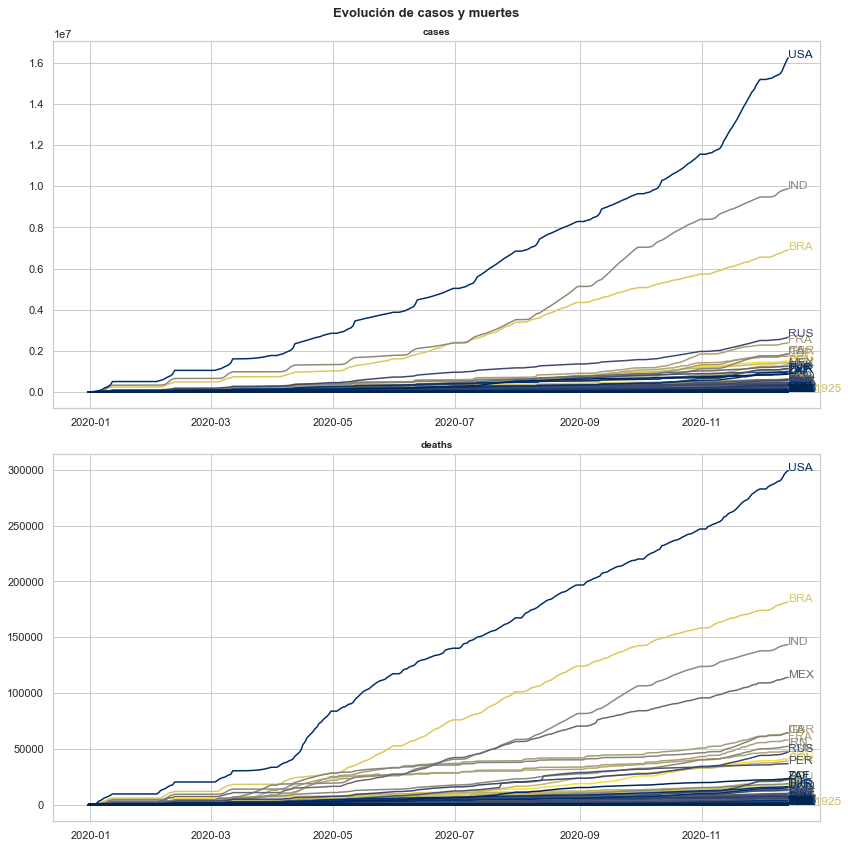

In [47]:
sns.set(rc={'figure.figsize':(12,12)})
sns.set_style("whitegrid")
fig,axes = plt.subplots(2,1)
fig.suptitle('Evolución de casos y muertes',fontweight ="bold", fontsize="13")

i=0
for col in ["cases","deaths"]:
    ax=sns.lineplot(data=ds_evolution,x="dateRep",y=col,hue=code,palette=cmap,ax=axes[i],legend=False)
    axes[i].set_title(col,fontweight ="bold",fontsize="10")
    axes[i].set(xlabel=None,ylabel=None)
    i+=1
    # Se añade texto para cada línea
    for line, name in zip(ax.lines, ds_evolution[code].unique().tolist()):
        y = line.get_ydata()[-1]
        x = line.get_xdata()[-1]     
        text = ax.annotate(name,xy=(x, y),xytext=(0, 0),color=line.get_color(),
                           xycoords=(ax.get_xaxis_transform(),ax.get_yaxis_transform()),textcoords="offset points")
        text_width = (text.get_window_extent(fig.canvas.get_renderer()).transformed(ax.transData.inverted()).width)
        if np.isfinite(text_width):
            ax.set_xlim(ax.get_xlim()[0], text.xy[0] + text_width * 1.05)
fig.tight_layout()
plt.show()

>Al graficar el atributo ***cases_14d_100K*** se observa un comportamiento diferente viendo más países con una afectación similar y solamente sobresale Andorra, seguido por Luxemburgo y Montengro.

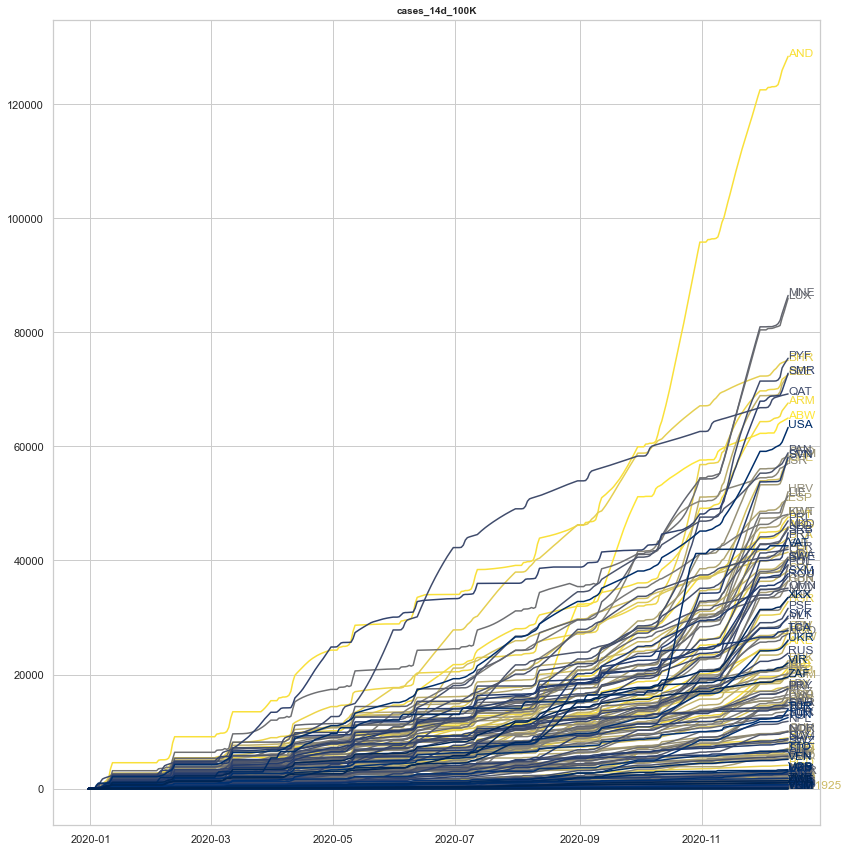

In [48]:
col="cases_14d_100K"
fig,axes = plt.subplots(1,1)
ax=sns.lineplot(data=ds_evolution,x="dateRep",y=col,hue=code,palette=cmap,ax=axes,legend=False)
axes.set_title(col,fontweight ="bold",fontsize="10")
axes.set(xlabel=None,ylabel=None)

i+=1
# Se añade texto para cada línea
for line, name in zip(ax.lines, ds_evolution[code].unique().tolist()):
    y = line.get_ydata()[-1]
    x = line.get_xdata()[-1]     
    text = ax.annotate(name,xy=(x, y),xytext=(0, 0),color=line.get_color(),
                       xycoords=(ax.get_xaxis_transform(),ax.get_yaxis_transform()),textcoords="offset points")
    text_width = (text.get_window_extent(fig.canvas.get_renderer()).transformed(ax.transData.inverted()).width)
    if np.isfinite(text_width):
        ax.set_xlim(ax.get_xlim()[0], text.xy[0] + text_width * 1.05)
fig.tight_layout()

Se analizan los países con mayor afectación en _número de casos_ y _muertes_. Se una la función ***barplot*** de **seaborn** <a name="ref-6"/>[(Seaborn, 2021)](#cite-seaborn-plot:2021), para tener una mejor visualización que en los gráficos anteriores.

>La gráfica muestra que los países con más muertes no son necesariamente los con más casos, por lo que existen más variables relacionadas con la mortalidad por causa del virus, las cuales se pretende aportar en el presente estudio. Además la variable población marca una diferencia primordial en el análisis de impacto.

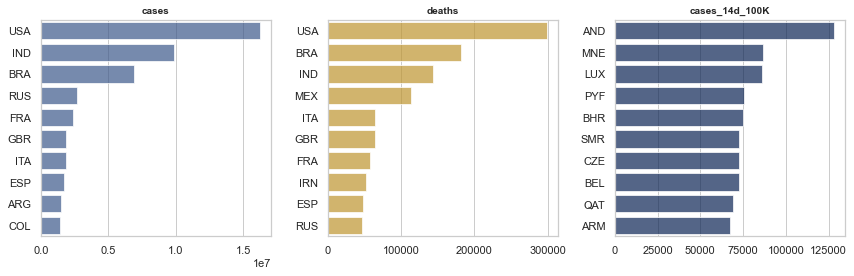

In [49]:
# Configuración área gráfica
sns.set(rc={'figure.figsize':(12,4)})
sns.set_style("whitegrid")
fig,axes = plt.subplots(1,3)
# Gráfico con barplot
i=0
for col in ["cases","deaths","cases_14d_100K"]:
    plot_order = ds.groupby(code)[col].sum().sort_values(ascending=False).index.values
    sns.barplot(data=ds,y=code,x=col,color=color[i],alpha=0.7,estimator=sum,ci=0,order=plot_order[:10],ax=axes[i])
    axes[i].set_title(col,fontweight ="bold",fontsize="10")
    axes[i].set(xlabel=None,ylabel=None)
    i+=1
    
fig.tight_layout()
#sns.despine()
plt.show()

Se analiza el promedio de otros factores que pueden incidir en el impacto de la pandemia en cada uno de los países. 
>De este gráfico se puede deducir que los países con mayor índice de restricciones y desarrollo humano, no aparecen entre aquellos con mayor impacto de la pandemia.

>Algunos de los países con mayor edad media y expectativa de vida están presentes en los países con mayor número de casos detectados y muertes, como es el caso de Italia y España; y también con los países de mayor impacto como es el caso de Andorra. Por lo que se consideran variables útiles para el análisis.

>Los países con mayores tasas de enfermedades cardiovasculares y diabetes no aparecen en entre los países con mayor impacto de mortalidad. Se tomará en cuenta este criterio en el momento del análisis.

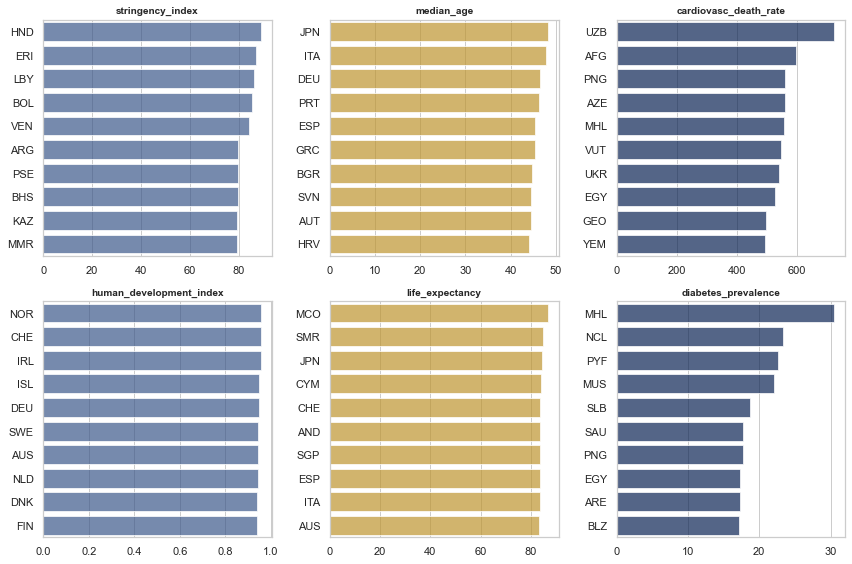

In [50]:
# Configuración área gráfica
sns.set(rc={'figure.figsize':(12,8)})
sns.set_style("whitegrid")
fig,axes = plt.subplots(2,3)

# Gráfico con barplot
i=0
for col in ["stringency_index","median_age","cardiovasc_death_rate","human_development_index","life_expectancy","diabetes_prevalence"]:
    plot_order = ds.groupby(code)[col].mean().sort_values(ascending=False).index.values
    sns.barplot(data=ds,y=code,x=col,color=color[i%3],alpha=0.7,ci=0,order=plot_order[:10],ax=axes[i//3,(i)%3])
    axes[i//3,(i)%3].set_title(col,fontweight ="bold",fontsize="10")
    axes[i//3,(i)%3].set(xlabel=None,ylabel=None)
    i+=1
    
fig.tight_layout()
#sns.despine()
plt.show()

Se grafica el top 10 de la taza de incidencia y de mortalidad, que pueden proporcionar una idea más clara del agrupamiento y clasificación posteriores. Aunque no se utilizarán estos campos para el análisis.

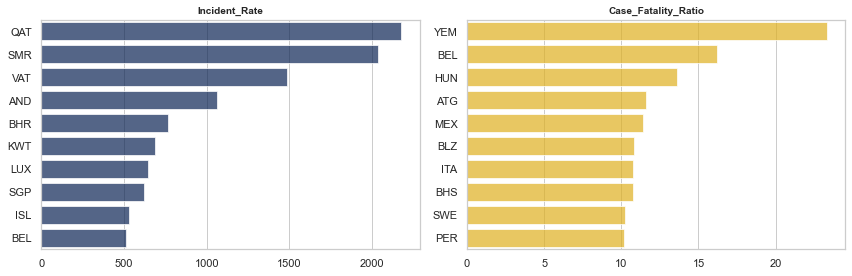

In [51]:
# Configuración área gráfica
sns.set(rc={'figure.figsize':(12,4)})
sns.set_style("whitegrid")
fig,axes = plt.subplots(1,2)

# Gráfico con barplot
i=0
for col in ["Incident_Rate","Case_Fatality_Ratio"]:
    plot_order = ds.groupby(code)[col].mean().sort_values(ascending=False).index.values
    sns.barplot(data=ds,y=code,x=col,color=color[i+2],alpha=0.7,ci=0,order=plot_order[:10],ax=axes[i])
    axes[i].set_title(col,fontweight ="bold",fontsize="10")
    axes[i].set(xlabel=None,ylabel=None)
    i+=1

fig.tight_layout()
#sns.despine()
plt.show()

>De las estadísticas se puede observar que los atributos ***cases*** y ***deaths*** tienen valores negativos, que no concuerda con los valores requeridos.

In [52]:
print(ds.describe())

               cases        deaths   popData2019  cases_14d_100K  \
count   61777.000000  61777.000000  6.177700e+04    59021.000000   
mean     1157.435858     26.107224  4.098770e+07       66.320586   
std      6785.775773    131.352497  1.531294e+08      162.329240   
min     -8261.000000  -1918.000000  8.150000e+02     -147.419587   
25%         0.000000      0.000000  1.293120e+06        0.757526   
50%        16.000000      0.000000  7.169456e+06        6.724045   
75%       276.000000      4.000000  2.851583e+07       52.572719   
max    234633.000000   4928.000000  1.433784e+09     1900.836210   

       reproduction_rate  stringency_index    median_age  \
count       41308.000000      47220.000000  48559.000000   
mean            1.047225         59.853741     31.031238   
std             0.394488         22.202816      9.123744   
min            -0.030000          0.000000     15.100000   
25%             0.860000         44.440000     22.900000   
50%             1.040000   

Se calcula el **coeficiente de variación** de los atributos de entrada.

In [53]:
# Cálculo del coeficiente de variación
print("\033[1mCoeficiente de Variación:\033[0m")
for col in ds:
    if pd.api.types.is_numeric_dtype(ds[col]):
        print(col,ds[col].std()/abs(ds[col].mean()))

Coeficiente de Variación:
cases 5.862766153665314
deaths 5.0312700948571925
popData2019 3.735983867249276
cases_14d_100K 2.44764483900344
reproduction_rate 0.3766979955866275
stringency_index 0.3709511886536296
median_age 0.29401802908088337
cardiovasc_death_rate 0.46683635947693425
diabetes_prevalence 0.5175181750837144
life_expectancy 0.10113628636930225
human_development_index 0.2051694267133005
Incident_Rate 2.1019505223667476
Case_Fatality_Ratio 1.0402339799096911


Se realiza un gráfico de coropletas con los atributos ***Incident_Rate*** y ***Case_Fatality_Radio***.  Para mejorar la apariencia de los gráficos se consulta la biblioteca de colores de Matplotlib <a name="ref-7"/>[(Matplotlib, 2022)](#cite-MPL-CR)
>El gráfico muesta que la tasa de incidencia en África aparentemente es baja, pero la mortalidad por otra parte incrementa en este continente. En cambio aunque Rusia es un país con incidencia alta no está entre los países con mayor mortalidad.

In [54]:
# Función para crear los gráficos geográficos, siempre con la misma apariencia
def map_plot(ds_map,column,scheme,title):
    sns.set(rc={'figure.figsize':(14,10)})
    sns.set_style("white")
    fig, ax = plt.subplots(1, 1)

    ds_map.plot(column=column,ax=ax,cmap=cmap, scheme=scheme, legend=True,legend_kwds={'loc': 'lower left'})
    ax.set_title(title,fontweight ="bold",fontsize="15")
    fig.tight_layout()
    plt.show()

In [55]:
# Función para crear el dataset geográfico con la unión con el dataset world
def create_ds_map(ds_map):
    ds_map=pd.merge(ds_map,world[["iso_a3","geometry"]],left_on=[code],
                    right_on=["iso_a3"],
                    how='left',indicator=False).drop(columns=["iso_a3"])
    ds_map=gpd.GeoDataFrame(ds_map) # conversión a dataset geográfico
    return ds_map

In [56]:
ds_map=ds[[code,"Incident_Rate","Case_Fatality_Ratio"]].groupby(code).mean().dropna()
ds_map=create_ds_map(ds_map)

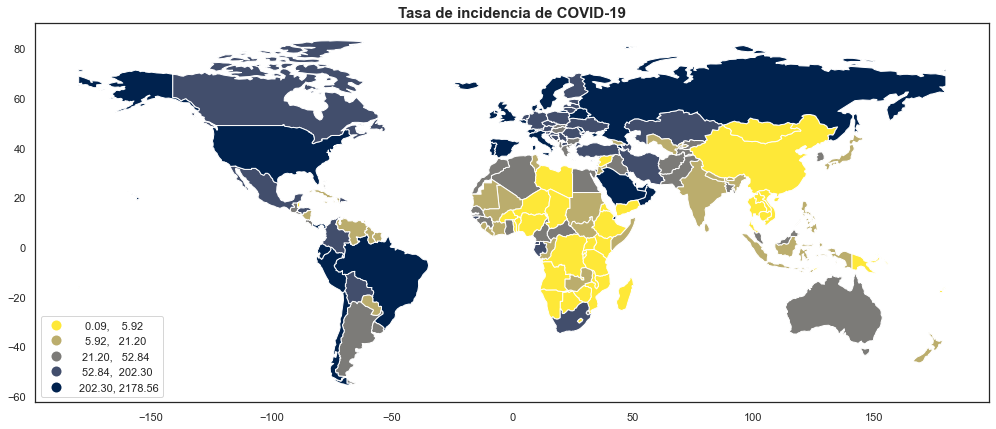

In [57]:
map_plot(ds_map,"Incident_Rate","quantiles","Tasa de incidencia de COVID-19")

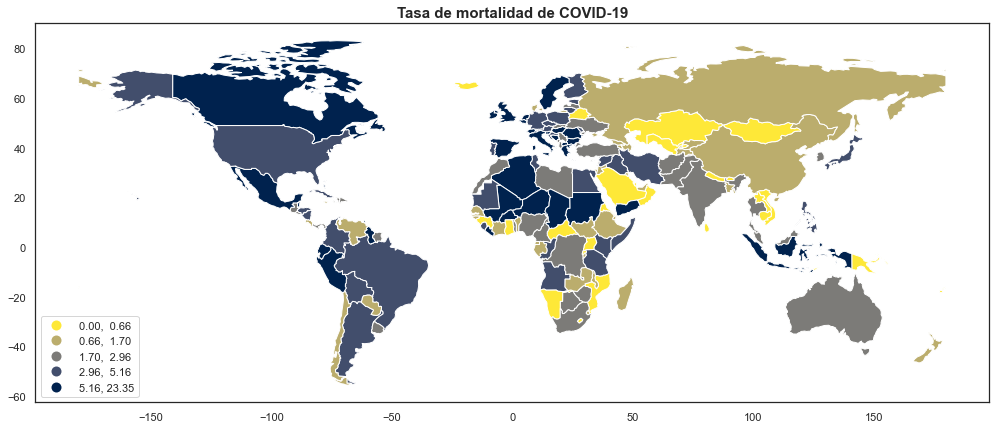

In [58]:
map_plot(ds_map,"Case_Fatality_Ratio","quantiles","Tasa de mortalidad de COVID-19")

Se grafica la distribución de los atributos de entrada numéricos.
>De la gráfica se puede deducir que: 
>- Los atributos ***cases*** y ***deaths*** no tienen una distribución normal, más bien tienen una alta concentración en valores relativamente bajos respecto a su rango. Lo mismo puede decirse de los atributos ***icu_patients*** y ***hosp_patients***
>- 

[]

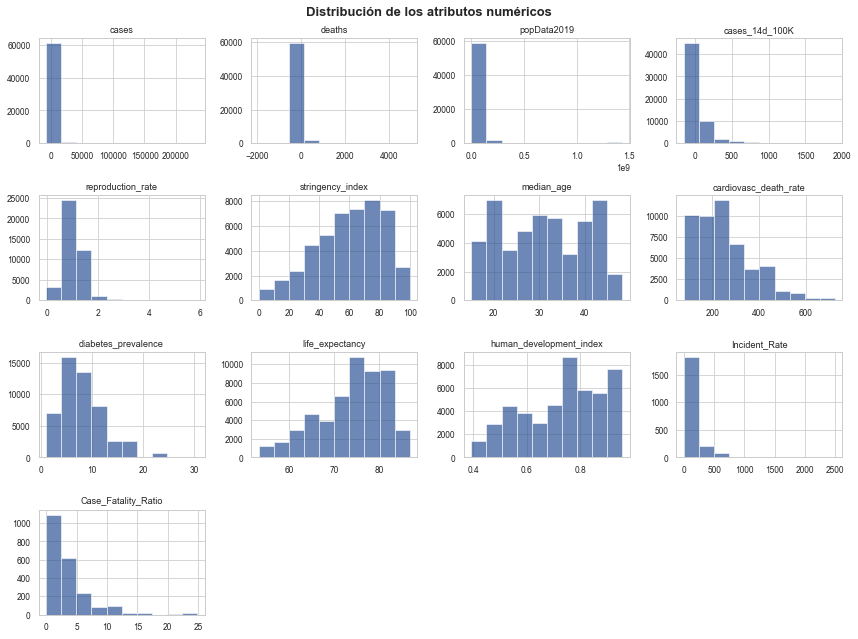

In [60]:
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("paper",font_scale=0.95, rc={"lines.linewidth": 1.5})
ds.hist(figsize=(12, 9), column=ds.columns[1:],color=color[0],alpha=.7)
plt.suptitle("Distribución de los atributos numéricos",fontweight ="bold", fontsize="13")
plt.subplots_adjust(top=1)
plt.tight_layout()
plt.plot()

Se realiza el diagrama de correlación para conocer de modo general el comportamiento por pares de los atributos.

[]

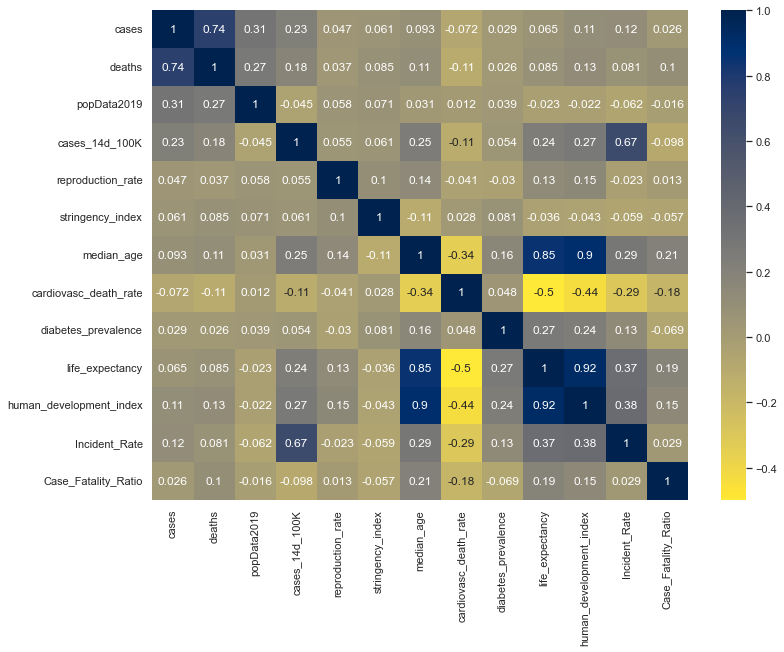

In [61]:
sns.set(rc={'figure.figsize':(12,9)})
sns.heatmap(ds.corr(),annot=True,cmap=cmap)
plt.plot()

## Análisis de impacto a través de algoritmos de clustering
Se aplica algoritmos de clustering para dividir los datos en grupos y determinar el impacto en base a los atributos que se posee. Se definen **cinco grupos** para considerar diferentes niveles de impacto, similar a la escala obtenida en el Análisis Exploratorio de Datos (EDA) para las tasas de incidencia y mortalidad. Se pretendería definir un impacto por grados: _Leve, Moderado, Medio, Alto y Grave_. Sin embargo, se analizará los resultados arrojados por los algoritmos.

In [847]:
n_clusters=5
clusters_names=["Leve","Moderado","Medio","Alto","Grave"]

### Dataset con campos acumulados
Se realiza la agrupación en primer lugar usando campos acumulados (***cases***, ***deaths***, ***popData2019***) y directamente relacionados con la pandemia.

In [849]:
ds_train=ds_evolution[["dateRep",code,"cases","deaths"]]
ds_train=pd.merge(ds_train,ds[["dateRep",code,"popData2019"]],on=["dateRep",code],how='inner',indicator=False).drop("dateRep",axis=1)#.dropna()

Usando **LabelEncoder**  se transforma la columna que contiene el código del país a numérica, ya que los algoritmos no trabajan con valores categóricos.

In [918]:
le = LabelEncoder()
ds_train[code] = le.fit_transform(ds_train[code])

In [919]:
X = ds_train.values 

Se realiza una transformación inversa de LabelEncoder para obtener los códigos de los países.

In [920]:
ds_train[code] = le.inverse_transform(ds_train[code])

In [921]:
ds_train.head()

,countryterritoryCode,cases,deaths,popData2019
0,ABW,5,0,106310.0
1,ABW,5,0,106310.0
2,ABW,5,0,106310.0
3,ABW,5,0,106310.0
4,ABW,6,0,106310.0


Al ser una variable nominal, también se transforma el código del país a númerica, usando **OneHotEncoder** que es la mejor opción para este tipo de variables. Se crea un nuevo array ***X_OneHot*** para las pruebas con esta transformación.

In [854]:
enc = OneHotEncoder()

enc_key = pd.DataFrame(enc.fit_transform(ds_train[[code]]).toarray())
ds_code = ds_train.join(enc_key).drop(code,axis=1)

In [855]:
X_OneHot=ds_code.values

#### Algoritmo KPrototypes
El algoritmo **KPrototypes** usa un esquema similar al algoritmo KMeans de sklearn, pero permite el uso datos combinados: númericos y categóricos<a name="ref-8"/>[(PyPi, 2022)](#cite-KP). Debido a la información que se posee del código de país se usa en primer lugar este algoritmo para agrupar el impacto de COVID-19 y comparar su desempeño con los algoritmos de clustering de **Sklearn**.
>Durante el entrenamiento se observa que este algoritmo tiene un alto costo computacional, pero posee resultados robustos con pocos hiperparámetros.

In [856]:
kproto = KPrototypes(n_clusters=n_clusters) #se selecciona el número de clústers
clusters = kproto.fit_predict(ds_train, categorical=[0]) #en el método fit se seleccionan los campos categóricos
# Se crea el dataframe con los resultados
labels = pd.DataFrame(clusters)
ds_accum = pd.concat((ds_train,labels),axis=1)
ds_accum = ds_accum.rename({0:"c_KPrototype"},axis=1)

In [862]:
ds_map=ds_accum.groupby([code,"c_KPrototype"]).size().reset_index()
ds_map.drop(ds_map[ds_map[0] == 0 ].index,inplace=True)
ds_map.drop(0,inplace=True,axis=1)

In [863]:
ds_map=ds_map.groupby([code,"c_KPrototype"]).size().reset_index()
ds_map=create_ds_map(ds_map)

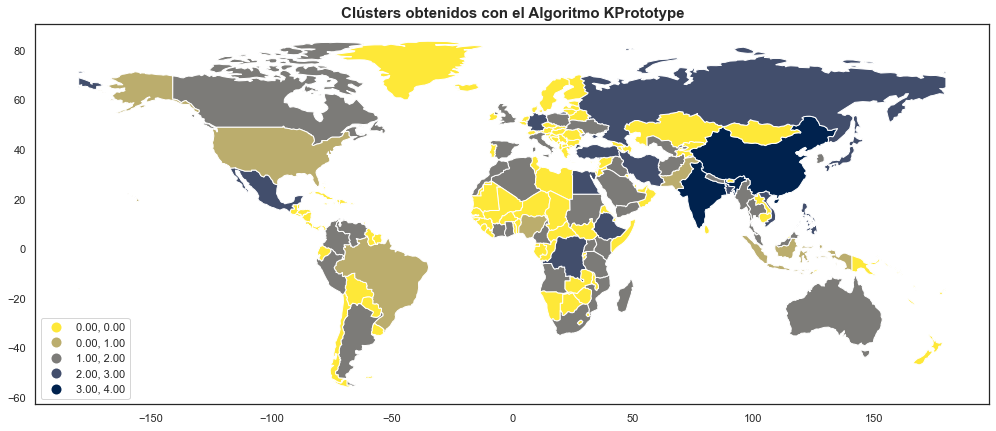

In [864]:
map_plot(ds_map,"c_KPrototype","natural_breaks","Clústers obtenidos con el Algoritmo KPrototype")

#### Algoritmo KMeans sin OneHotEncoder
Se usa el algoritmo **KMeans** para crear tres clústers. Se toma como base el código del ejercicio provisto en clases.<a name="ref-9"/>[(Scikitlearn, 2022)](#cite-SKL-KM)

In [865]:
# definimos y ajustamos el modelo
model = KMeans(n_clusters=n_clusters)
model.fit(X)
# se predice el clúster para cada elemento del array de entrada
yhat = model.predict(X)

In [866]:
ds_accum["c_KMeans"]=yhat

In [867]:
ds_map=ds_accum.groupby([code,"c_KMeans"]).size().reset_index()
ds_map.drop(ds_map[ds_map[0] == 0 ].index,inplace=True)
ds_map.drop(0,inplace=True,axis=1)

In [868]:
ds_map=ds_map.groupby([code,"c_KMeans"]).size().reset_index()
ds_map=create_ds_map(ds_map)

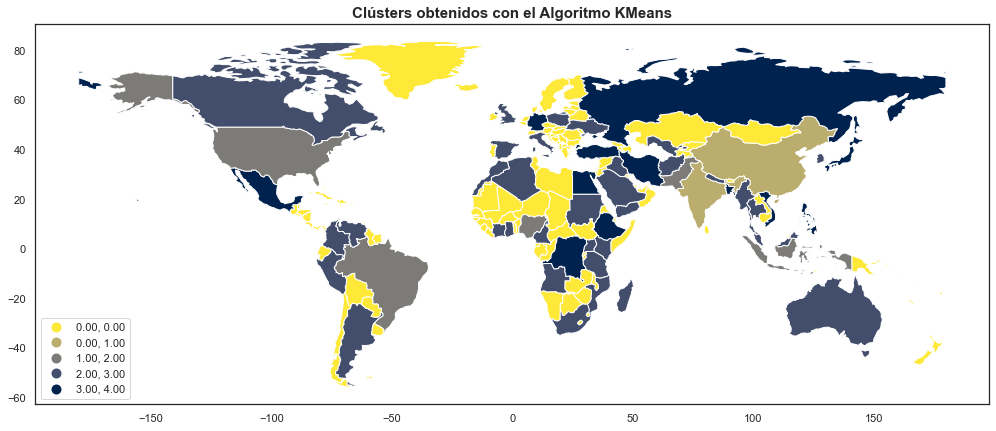

In [869]:
map_plot(ds_map,"c_KMeans","natural_breaks","Clústers obtenidos con el Algoritmo KMeans")

#### Algoritmo Gaussian Mixture
Se prueba también el algoritmo Gaussian Mixture <a name="ref-10"/>[(UNDEFINED)](#cite-sklearn-GM), obteniendo los mismos resultados que con el algoritmo KMeans.

In [922]:
# definimos y ajustamos el modelo
model = GaussianMixture(n_components=n_clusters)
model.fit(X)
# predecimos los clúster
yhat = model.predict(X)

In [923]:
ds_accum["c_GMixture"]=yhat

Este algoritmo posee más filas que número de países, lo que implica que varios países están asignados a más de un clúster. Para la gráfica se toma el grupo con más instancias asignadas.

In [931]:
ds_map=ds_accum.groupby([code,"c_GMixture"]).size().reset_index()

In [934]:
ds_map=ds_map.groupby(code).max()
ds_map=create_ds_map(ds_map)

In [935]:
ds_map.shape()

TypeError: 'tuple' object is not callable

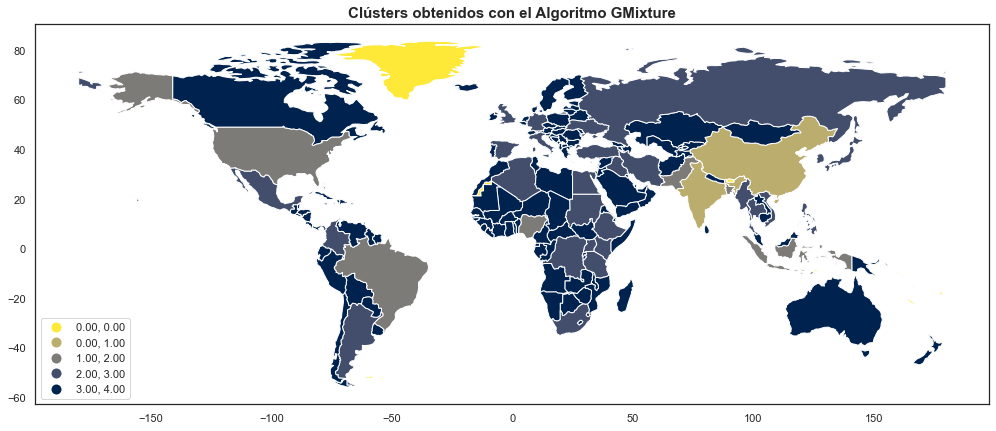

In [937]:
map_plot(ds_map,"c_GMixture","natural_breaks","Clústers obtenidos con el Algoritmo GMixture")

#### Algoritmo KMeans con OneHotEncoder
Se aplica el mismo algoritmo inicial pero usando el dataset transformado con OneHotEncoder para la conversión de los países.

In [874]:
# definimos y ajustamos el modelo
model = KMeans(n_clusters=n_clusters)
model.fit(X_OneHot)
# se predice el clúster para cada elemento del array de entrada
yhat = model.predict(X_OneHot)

In [875]:
ds_accum["c_wOneHot"]=yhat

In [876]:
ds_map=ds_accum.groupby([code,"c_wOneHot"]).size().reset_index()
ds_map.drop(ds_map[ds_map[0] == 0 ].index,inplace=True)
ds_map.drop(0,inplace=True,axis=1)

In [877]:
ds_map=ds_map.groupby([code,"c_wOneHot"]).size().reset_index()
ds_map=create_ds_map(ds_map)

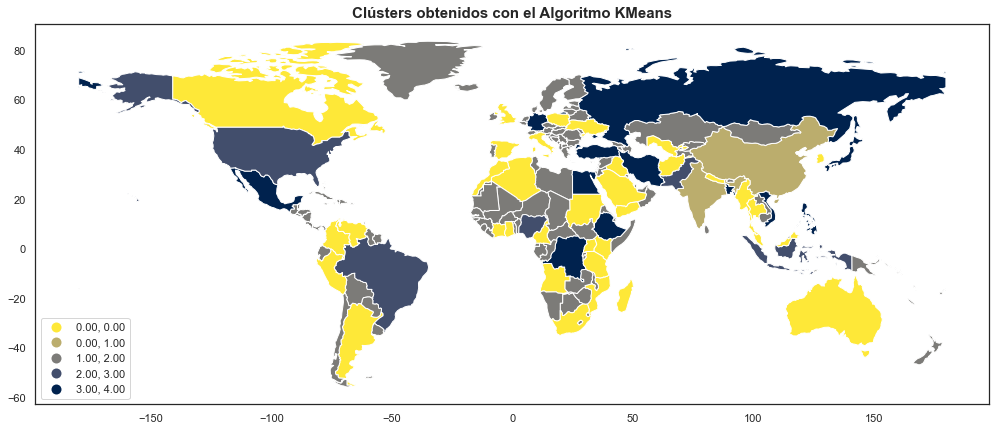

In [878]:
map_plot(ds_map,"c_wOneHot","natural_breaks","Clústers obtenidos con el Algoritmo KMeans")

#### Comparación de los algoritmos
Se realiza un análisis comparativo de los cuatro algoritmos.
>Los algoritmos basados en distancias presentan la misma distribución.

In [887]:
ds_accum

,countryterritoryCode,cases,deaths,popData2019,c_KPrototype,c_KMeans,c_GMixture,c_wOneHot
0,ABW,5,0,106310.0,0,0,2,2
1,ABW,5,0,106310.0,0,0,2,2
2,ABW,5,0,106310.0,0,0,2,2
3,ABW,5,0,106310.0,0,0,2,2
4,ABW,6,0,106310.0,0,0,2,2
...,...,...,...,...,...,...,...,...
61772,ZWE,11024,305,14645473.0,0,0,4,2
61773,ZWE,11081,305,14645473.0,0,0,4,2
61774,ZWE,11162,306,14645473.0,0,0,4,2
61775,ZWE,11219,307,14645473.0,0,0,4,2


Para cada algoritmo entrenado se realiza una validación de los grupos para conocer las características de cada uno. En todos los casos la media de los casos tiene relación directamente proporcional con el número de muertes.
>Para el algoritmo **KPrototype** el impacto de los grupos podría interpretarse como:
>- Clúster 1: Impacto Grave
>- Clúster 4: Impacto Alto
>- Clúster 3: Impacto Medio
>- Clúster 2: Impacto Moderado
>- Clúster 0: Impacto Leve

>Para el algoritmo **GMixture** el impacto se puede observar como:
>- Clúster 1: Impacto Grave
>- Clúster 3: Impacto Alto
>- Clúster 4: Impacto Medio
>- Clúster 0: Impacto Moderado
>- Clúster 2: Impacto Leve

In [904]:
for algorimth in ["c_KPrototype","c_KMeans","c_GMixture","c_wOneHot"]:
    ds_cluster=ds_accum.groupby(algorimth).agg(cases_mean=("cases","mean"),deaths_mean=("deaths","mean"),
                                              count=(code,pd.Series.nunique)).sort_values(["cases_mean","deaths_mean"],ascending = [False, False])
    print("\033[1m{:}\033[0m".format(algorimth))
    print(ds_cluster)

c_KPrototype
                cases_mean   deaths_mean  count
c_KPrototype                                   
1             1.797981e+06  44549.029531      5
4             1.785380e+06  28388.608011      2
3             2.813755e+05   9602.989723     12
2             1.880112e+05   6309.026822     35
0             2.749319e+04    594.230427    158
c_KMeans
            cases_mean   deaths_mean  count
c_KMeans                                   
2         1.797981e+06  44549.029531      5
1         1.785380e+06  28388.608011      2
4         2.813755e+05   9602.989723     12
3         1.880112e+05   6309.026822     35
0         2.749319e+04    594.230427    158
c_GMixture
              cases_mean   deaths_mean  count
c_GMixture                                   
1           1.785380e+06  28388.608011      2
3           7.240447e+05  21530.041182     48
4           4.753563e+04    843.065673    116
0           3.548837e+03     55.031875    143
2           1.813690e+02      2.371811     63
c

Se realiza una gráfica comparativa de la distribución de cada algoritmo
>Los algoritmos **KPrototype** y **KMeans** (con y sin OneHotEncoder) presentan la misma distribución en los clústers. 

>El algoritmo **GMixture** por otra parte, agrupa los países de diferentes categorías, generando su participación en dos grupos. En la gráfica de coropletas se consideró el clúster con más frecuencia. Sin embargo, se entiende que al emplear los algoritmos tradicionales,no se toma en cuenta la temporalidad y el código de país interviene como un atributo adicional que no tiene por qué ser considerado dentro de un mismo clúster. El que un país pertenezca a más de un clúster puede implicar cambios en la situación de dicho país según la evolución de la pandemia.

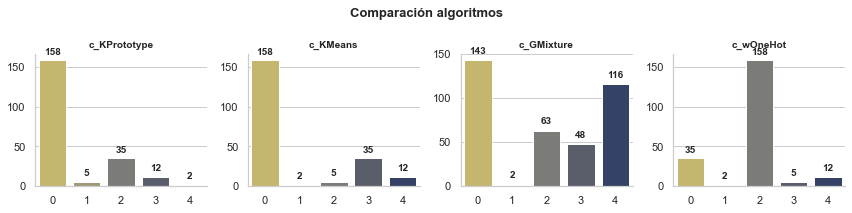

In [886]:
sns.set(rc={'figure.figsize':(12,3)})
sns.set_style("whitegrid")
fig,axes = plt.subplots(1,4)
fig.suptitle('Comparación algoritmos',fontweight ="bold", fontsize="13")

i=0
for algorimth in ["c_KPrototype","c_KMeans","c_GMixture","c_wOneHot"]:
    ax=sns.countplot(data=ds_accum.groupby([code,algorimth]).size().reset_index(),x=algorimth,palette=cmap,ax=axes[i])
    axes[i].set_title(algorimth,fontweight ="bold",fontsize="10")
    axes[i].set(xlabel=None,ylabel=None)
    for p in ax.patches:
       ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()+7.5), ha='center', size=10, weight='bold')
    i+=1

plt.subplots_adjust(top=1)
plt.tight_layout()
sns.despine()
plt.show()
    

### Dataset con tasas de incidencia
Se prepara un nuevo dataset, usando en este caso la incidencia y el índice de mortalidad, parámetros que ya están relacionados con la población. El dataset inicial posee ya este cálculo importado del dataset de CSSE, pero tiene un número reducido de países por lo que se analiza la factibilidad de calcular dichos atributos y no disminuir drásticamente el número de países de estudio:
- ***Incidencia acumulada:*** _se calcula dividiendo el número de casos aparecidos en un periodo entre el número de personas que están libres de la enfermedad al inicio del período_ <a name="ref-11"/>[(Sanitaria, 2022)](#cite-CV19-IncidentRate). Este campo ya se encuentra en el dataset y correspondería a ***cases_14d_100K***.
- ***Índice de mortalidad (IFR):*** _La verdadera gravedad de una enfermedad puede definirse por la razón de letalidad de la infección_<a name="ref-12"/>[(OMS, 2020)](#cite-CV19-FatalitytRate). Puede calcularse con los datos presentes:

$$IFR=\frac{Muertes\_por\_la\_enfermedad}{Personas\_infectadas}$$

In [754]:
ds_rates=ds[[code,"cases_14d_100K"]]
ds_rates["IFR"]=ds["deaths"]/ds["cases"]

In [888]:
# Se reemplaza los valores infinitos por NAN y se eliminan.
ds_rates.replace([np.inf, -np.inf], np.nan, inplace=True)
ds_rates.dropna(inplace=True)

In [768]:
ds_rates

,countryterritoryCode,cases_14d_100K,IFR
0,AFG,9.013779,0.008043
1,AFG,7.052776,0.030201
2,AFG,6.868768,0.097345
3,AFG,7.134266,0.158730
4,AFG,6.968658,0.079208
...,...,...,...
61752,ZWE,0.068280,0.000000
61754,ZWE,0.047796,0.000000
61757,ZWE,0.054624,1.000000
61758,ZWE,0.054624,0.000000


In [889]:
ds_rates.isna().sum()

countryterritoryCode    0
cases_14d_100K          0
IFR                     0
c_KMeans                0
dtype: int64

Usando **LabelEncoder** se convierte a númerico el código de país. Se usa este criterio ya que se observaron los mismos resultados que usando _OneHotEncoder_

In [939]:
le = LabelEncoder()
ds_rates[code] = le.fit_transform(ds_rates[code])

In [940]:
X = ds_rates.values 

In [941]:
ds_rates[code] = le.inverse_transform(ds_rates[code])

#### Algoritmo KMeans

In [942]:
# definimos y ajustamos el modelo
model = KMeans(n_clusters=n_clusters)
model.fit(X)
# se predice el clúster para cada elemento del array de entrada
yhat = model.predict(X)

In [943]:
ds_rates["c_KMeans"]=yhat

In [945]:
ds_map=ds_rates.groupby([code,"c_KMeans"]).size().reset_index()
ds_map.shape

(400, 3)

In [952]:
ds_rates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41365 entries, 0 to 61762
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   countryterritoryCode  41365 non-null  object 
 1   cases_14d_100K        41365 non-null  float64
 2   IFR                   41365 non-null  float64
 3   c_KMeans              41365 non-null  int32  
dtypes: float64(2), int32(1), object(1)
memory usage: 1.4+ MB


In [953]:
algorimth="c_KMeans"
ds_cluster=ds_rates.groupby(algorimth).agg(cases_mean=("cases_14d_100K","mean"),deaths_mean=("IFR","mean"),
                                           count=(code,pd.Series.nunique)).sort_values(["cases_mean","deaths_mean"],ascending = [False, False])
print("\033[1m{:}\033[0m".format(algorimth))
print(ds_cluster)

c_KMeans
           cases_mean  deaths_mean  count
c_KMeans                                 
1         1160.173966     0.014936     23
4          583.426156     0.018336     61
0          226.625470     0.025841    106
2           25.563275     0.038153    109
3           24.425657     0.031935    101


In [946]:
ds_map=ds_map.groupby(code).max()
ds_map=create_ds_map(ds_map)
ds_map.shape

(211, 3)

Se analiza el comportamiento del algoritmo KMeans con las tasas. 
El algoritmo muestra resultados similares a los anteriormente entrenados, con la constante de que los países **India** y **China** los muestra en un grupo separado. Considerando que en esta caso no se esta tomando como atributo de entrada.

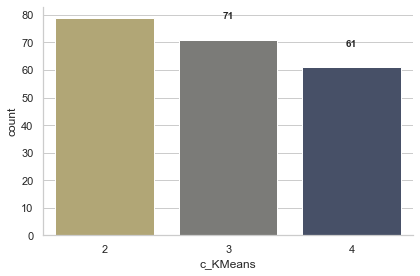

In [947]:
sns.set(rc={'figure.figsize':(6,4)})
sns.set_style("whitegrid")
ax=sns.countplot(data=ds_map,x="c_KMeans",palette=cmap)
for p in ax.patches:
   ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()+7.5), ha='center', size=10, weight='bold')
plt.tight_layout()
sns.despine()
plt.show()

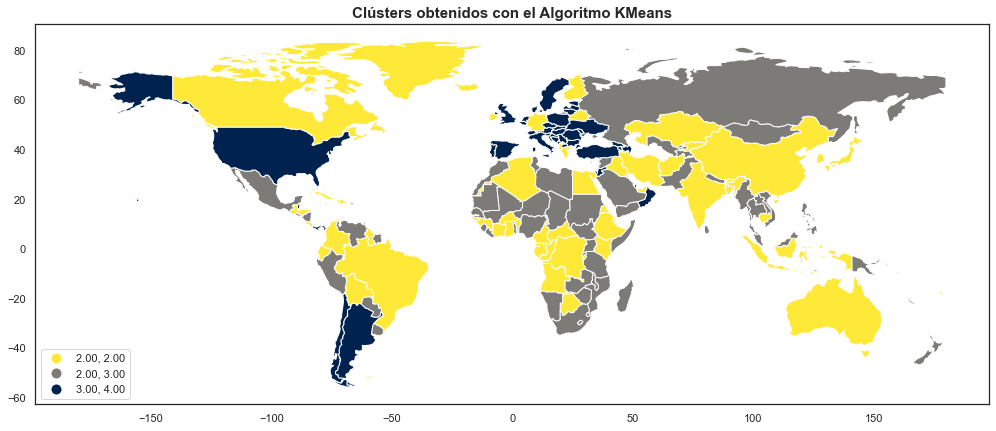

In [948]:
map_plot(ds_map,"c_KMeans","natural_breaks","Clústers obtenidos con el Algoritmo KMeans")

In [781]:
ds_map[ds_map["c_KMeans"]==1]

,countryterritoryCode,c_KMeans,0,geometry
36,CHN,1,350,"MULTIPOLYGON (((109.47521 18.19770, 108.65521 ..."
91,IND,1,349,"POLYGON ((97.32711 28.26158, 97.40256 27.88254..."


### Dataset Agrupado
Tomando en cuenta que en los dos puntos anteriores no se ha considerado la evolución temporal y se ha descartado la fecha, lo cual puede tener un impacto en la agrupación, para usar los métodos de clustering convencionales se crea un dataset que elimina la temporalidad y contiene los valores resumen de los campos ***cases***, ***deaths*** y ***popData2019***.

In [954]:
ds_group=ds_train.groupby(code).agg(cases=('cases','sum'), 
                         deaths=('deaths','sum'), 
                         popData2019=('popData2019','mean'))

In [955]:
ds_group.head()

,cases,deaths,popData2019
countryterritoryCode,,,
ABW,532171,5112,106310.0
AFG,7843873,288858,38041757.0
AGO,1482574,36783,31825299.0
AIA,1809,0,14872.0
ALB,4634190,108352,2862427.0


In [956]:
X=ds_group

#### Algoritmo K-Means

In [1160]:
# definimos y ajustamos el modelo
model = KMeans(n_clusters=n_clusters)
model.fit(X)
# se predice el clúster para cada elemento del array de entrada
yhat = model.predict(X)

In [1161]:
ds_group["c_KMeans"]=yhat

In [1162]:
ds_map=ds_group.groupby([code,"c_KMeans"]).size().reset_index()
ds_map=create_ds_map(ds_map)

In [1163]:
ds_map.head()

,countryterritoryCode,c_KMeans,0,geometry
0,ABW,0,1,None
1,AFG,0,1,"POLYGON ((66.51861 37.36278, 67.07578 37.35614..."
2,AGO,0,1,"MULTIPOLYGON (((12.99552 -4.78110, 12.63161 -4..."
3,AIA,0,1,None
4,ALB,0,1,"POLYGON ((21.02004 40.84273, 20.99999 40.58000..."


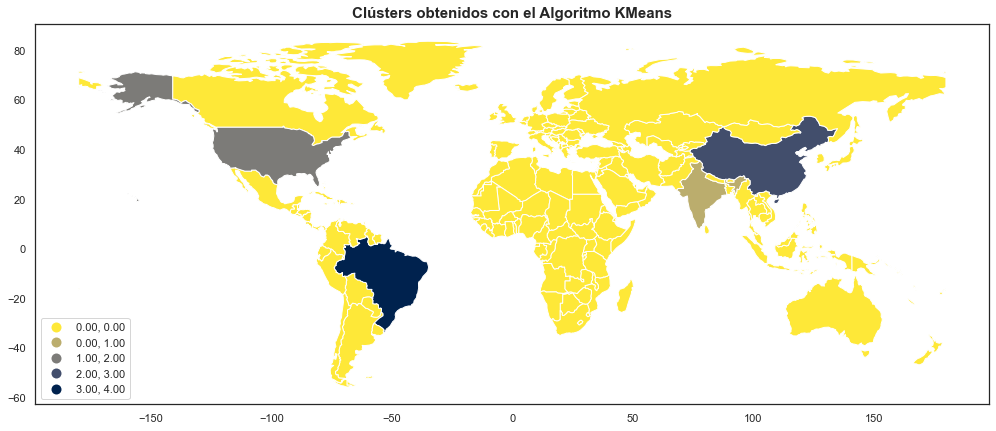

In [1164]:
map_plot(ds_map,"c_KMeans","natural_breaks","Clústers obtenidos con el Algoritmo KMeans")

#### Algoritmo Gaussian Mixture
Se prueba también el algoritmo Gaussian Mixture [](#cite), obteniendo los mismos resultados que con el algoritmo KMeans.

In [962]:
# definimos y ajustamos el modelo
model = GaussianMixture(n_components=n_clusters, reg_covar=1e-02)
model.fit(X)
# predecimos los clúster
yhat = model.predict(X)

In [963]:
ds_group["c_GMixture"]=yhat

In [964]:
ds_map=create_ds_map(ds_group)

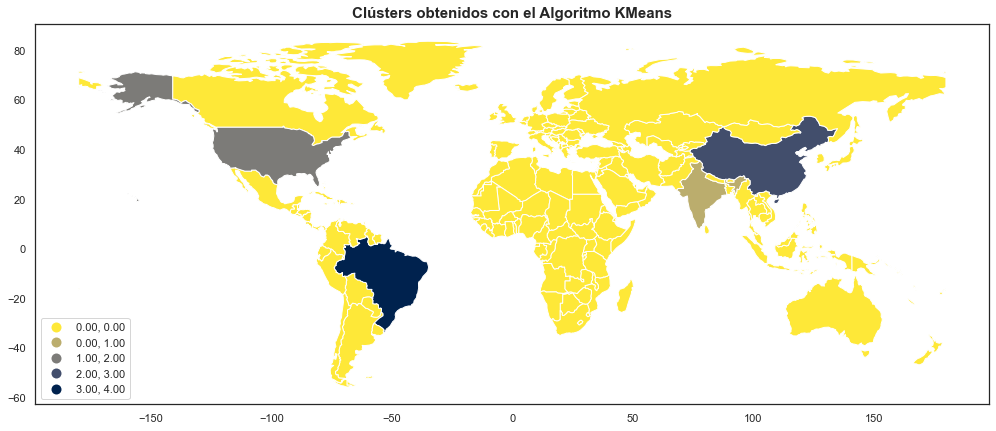

In [965]:
map_plot(ds_map,"c_GMixture","natural_breaks","Clústers obtenidos con el Algoritmo KMeans")

#### Algoritmo Fuzzy cmeans
_Los principios de la lógica difusa se pueden utilizar para agrupar datos multidimensionales, asignando a cada punto una pertenencia en cada centro de agrupación del 0 al 100 por ciento_ <a name="ref-13"/>[(SciKit-Fuzzy, 2022)](#cite-PH-FCM).

In [966]:
fcm = FCM(n_clusters=n_clusters)
fcm.fit(np.array(X))
fcm_centers = fcm.centers
fcm_labels = fcm.predict(np.array(X))

In [967]:
ds_group["c_FCM"]=fcm_labels

In [968]:
ds_map=create_ds_map(ds_group)

In [969]:
ds_map.head()

,cases,deaths,popData2019,c_KMeans,c_GMixture,c_FCM,geometry
0,532171,5112,106310.0,0,0,4,None
1,7843873,288858,38041757.0,0,0,4,"POLYGON ((66.51861 37.36278, 67.07578 37.35614..."
2,1482574,36783,31825299.0,0,0,4,"MULTIPOLYGON (((12.99552 -4.78110, 12.63161 -4..."
3,1809,0,14872.0,0,0,4,None
4,4634190,108352,2862427.0,0,0,4,"POLYGON ((21.02004 40.84273, 20.99999 40.58000..."


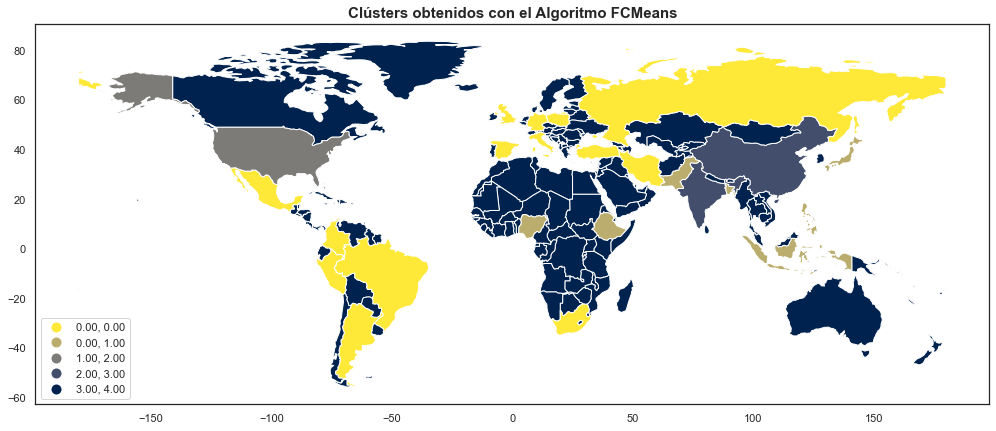

In [970]:
map_plot(ds_map,"c_FCM","natural_breaks","Clústers obtenidos con el Algoritmo FCMeans")

#### Comparación de los algoritmos
Se analiza un análisis comparativo de los tres algoritmos. En general se observa que al trabajar con valores resumen la agrupación es mucho más generalista y disminuyen datos de los puntos intermedios.
>El algoritmo **fcmeans** es el que logra mejor discriminación entre los grupos.

In [669]:
ds_group

,cases,deaths,popData2019,c_KMeans,c_FCM,c_GMixture
countryterritoryCode,,,,,,
ABW,532171,5112,106310.0,1,2,0
AFG,7843873,288858,38041757.0,1,2,0
AGO,1482574,36783,31825299.0,1,2,0
AIA,1809,0,14872.0,1,2,0
ALB,4634190,108352,2862427.0,1,2,0
...,...,...,...,...,...,...
XKX,4483190,131354,1798506.0,1,2,0
YEM,303567,89015,29161922.0,1,2,0
ZAF,112303528,2842172,58558267.0,1,0,0


Para cada algoritmo entrenado se realiza una validación de los grupos para conocer las características de cada uno.

In [974]:
for algorimth in ["c_KMeans","c_GMixture","c_FCM"]:
    ds_cluster=ds_group.reset_index().groupby(algorimth).agg(cases_mean=("cases","mean"),deaths_mean=("deaths","mean"),
                                              count=(code,pd.Series.nunique)).sort_values(["cases_mean","deaths_mean"],ascending = [False, False])
    print("\033[1m{:}\033[0m".format(algorimth))
    print(ds_cluster)

c_KMeans
            cases_mean   deaths_mean  count
c_KMeans                                   
2         2.006647e+09  4.604032e+07      1
1         1.225652e+09  1.867716e+07      1
4         9.512078e+08  2.698939e+07      1
3         2.232910e+07  1.166482e+06      1
0         2.144587e+07  6.467959e+05    208
c_GMixture
              cases_mean   deaths_mean  count
c_GMixture                                   
2           2.006647e+09  4.604032e+07      1
1           1.225652e+09  1.867716e+07      1
4           9.512078e+08  2.698939e+07      1
3           2.232910e+07  1.166482e+06      1
0           2.144587e+07  6.467959e+05    208
c_FCM
         cases_mean   deaths_mean  count
c_FCM                                   
2      2.006647e+09  4.604032e+07      1
3      6.239904e+08  9.921818e+06      2
0      2.277766e+08  7.878774e+06     15
1      4.322005e+07  9.238829e+05      7
4      9.052187e+06  1.971880e+05    187


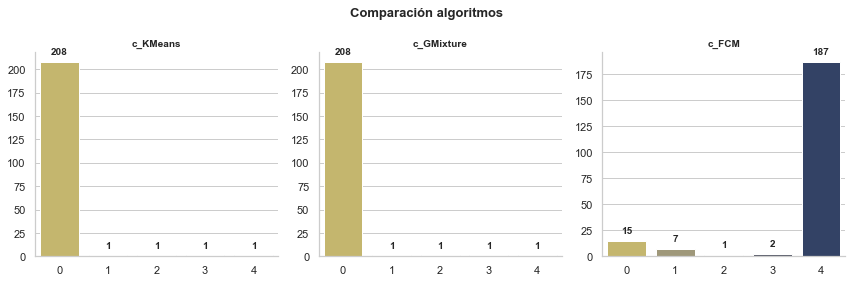

In [975]:
sns.set(rc={'figure.figsize':(12,4)})
sns.set_style("whitegrid")
fig,axes = plt.subplots(1,3)
fig.suptitle('Comparación algoritmos',fontweight ="bold", fontsize="13")

i=0
for algorimth in ["c_KMeans","c_GMixture","c_FCM"]:
    ax=sns.countplot(data=ds_map,x=algorimth,palette=cmap,ax=axes[i])
    axes[i].set_title(algorimth,fontweight ="bold",fontsize="10")
    axes[i].set(xlabel=None,ylabel=None)
    for p in ax.patches:
       ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()+7.5), ha='center', size=10, weight='bold')
    i+=1

plt.subplots_adjust(top=1)
plt.tight_layout()
sns.despine()
plt.show()
    

### Timeseries Dataset
Los análisis de los pasos previos no han considerado la temporalidad, en este apartado se realiza el análisis usando **tslearn** que  _es un paquete de Python que proporciona herramientas de aprendizaje automático para el análisis de series temporales_ <a name="ref-14"/>[(tsLearn, 2022)](#cite-TSL). 
> Se extrae inicialmente para el análisis Los campos ***casos*** y ***muertes*** y se transforma el dataset en uno adaptado a series temporales.

In [976]:
ds_time=ds[["dateRep",code,"cases","deaths","popData2019"]].sort_values([code,"dateRep"],ascending = [True, True])
ds_time["dateRep"]=ds_time["dateRep"].astype("string")

Se crea el array de las series temporales para cada uno de los países (un total de 212 series). <a name="ref-15"/>[(Kaggle, 2021)](#cite-KGL-TS)
>Al analizar las series se observa que no tienen el mismo tamaño,por lo que es necesario lograr uniformidad antes de entrenar los algoritmos.

In [977]:
mySeries = []
countries_list=ds_time[code].unique()
for country in countries_list:
    df=ds_time.loc[ds_train[code] == country][["dateRep","cases","deaths"]]
    df.set_index("dateRep",inplace=True)
    df.sort_index(inplace=True)
    mySeries.append(df)

In [978]:
len(mySeries)

212

In [979]:
series_lengths = [len(series) for series in mySeries]
print(series_lengths)

[267, 340, 268, 263, 281, 276, 344, 283, 341, 270, 350, 350, 343, 258, 350, 273, 257, 277, 275, 280, 349, 272, 277, 342, 266, 270, 277, 350, 272, 279, 276, 258, 274, 350, 350, 285, 350, 276, 277, 350, 277, 274, 279, 227, 269, 282, 275, 266, 270, 278, 350, 350, 271, 267, 350, 341, 345, 345, 346, 268, 233, 349, 345, 276, 346, 270, 255, 350, 284, 276, 350, 347, 270, 276, 270, 275, 272, 263, 275, 348, 267, 270, 275, 271, 275, 276, 347, 270, 284, 343, 269, 349, 348, 350, 348, 350, 347, 350, 277, 270, 277, 350, 275, 276, 271, 341, 264, 350, 347, 265, 346, 273, 265, 275, 279, 341, 214, 341, 343, 283, 280, 338, 280, 269, 280, 350, 47, 341, 264, 283, 267, 272, 274, 259, 267, 275, 268, 270, 256, 349, 275, 269, 269, 339, 271, 350, 350, 337, 341, 344, 345, 280, 282, 346, 269, 284, 262, 287, 278, 281, 271, 346, 348, 350, 275, 284, 276, 280, 350, 60, 258, 271, 349, 273, 280, 253, 250, 270, 282, 284, 350, 275, 264, 275, 267, 265, 270, 276, 343, 228, 268, 277, 281, 276, 273, 268, 276, 275, 350, 274, 2

>Se crea una lista de todas las series (países) que no poseen datos completos, ya que los valores representan nuevos casos y nuevas muertes, se rellena las fechas vacías con ceros.

In [980]:
longest_serie=mySeries[series_lengths.index(max(series_lengths))]
problem_indexes=[i for i in range(len(series_lengths)) if series_lengths[i] != max(series_lengths)]

In [981]:
for i in problem_indexes:
    for date in longest_serie.index:
        try:
            mySeries[i].loc[date]
        except:
            mySeries[i].loc[date]=[0,0]

Se transforma el array al tipo timeseries que se requiere para el entrenamiento de los algoritmos <a name="ref-16"/>[(tslearn, 2022)](#cite-TTSDUtil). Este es un array de tres dimensiones, en los que una de ellas corresponde a las diferentes series.

In [982]:
mySeries=to_time_series_dataset(mySeries)

#### Algoritmo Time Series KMeans

In [983]:
# definimos y ajustamos el modelo
model = tsKMeans(n_clusters=n_clusters,random_state=42,metric="dtw") # la métrica dtw es la que mejores resultados brinda con la temporalidad
model.fit(mySeries)
# se predice el clúster para cada elemento del array de entrada
yhat = model.predict(mySeries)

In [984]:
ds_map=pd.DataFrame({"countryterritoryCode":countries_list,"c_tsKMeans":yhat})

In [985]:
ds_map=create_ds_map(ds_map)

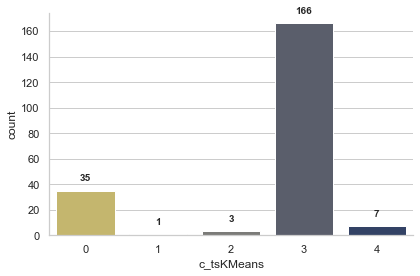

In [986]:
sns.set(rc={'figure.figsize':(6,4)})
sns.set_style("whitegrid")
ax=sns.countplot(data=ds_map,x="c_tsKMeans",palette=cmap)
for p in ax.patches:
   ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()+7.5), ha='center', size=10, weight='bold')
plt.tight_layout()
sns.despine()
plt.show()

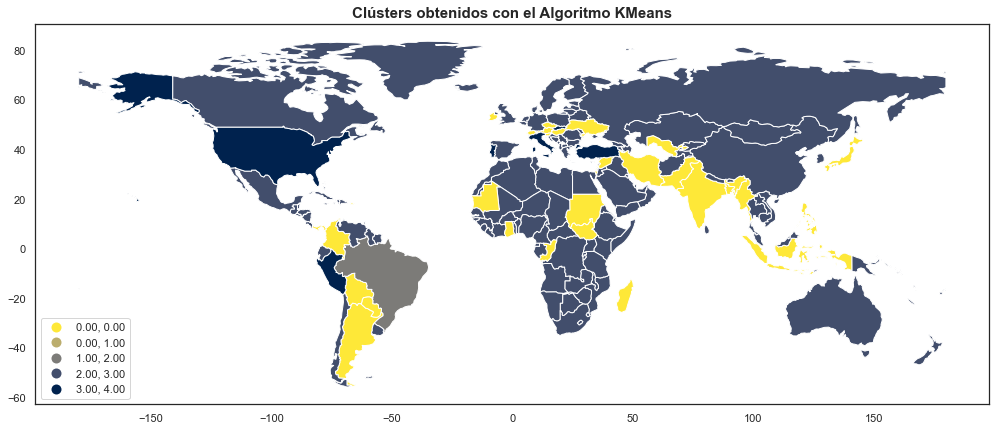

In [987]:
map_plot(ds_map,"c_tsKMeans","natural_breaks","Clústers obtenidos con el Algoritmo KMeans")

### Timeseries Dataset con incidencias
En esta caso se usan las tasas de incidencias en lugar de los valores absolutos.

In [989]:
ds_time_rates=ds[["dateRep",code,"cases_14d_100K"]].sort_values([code,"dateRep"],ascending = [True, True])
ds_time_rates["IFR"]=ds["deaths"]/ds["cases"]
ds_time_rates["dateRep"]=ds_time_rates["dateRep"].astype("string")

Se crea el array de las series temporales para cada uno de los países (un total de 212 series).

In [991]:
mySeries = []
countries_list=ds_time_rates[code].unique()
for country in countries_list:
    df=ds_time_rates.loc[ds_time_rates[code] == country][["dateRep","cases_14d_100K","IFR"]]
    df.set_index("dateRep",inplace=True)
    df.sort_index(inplace=True)
    mySeries.append(df)

In [992]:
len(mySeries)

212

In [993]:
series_lengths = [len(series) for series in mySeries]
print(series_lengths)

[267, 340, 268, 263, 281, 276, 344, 283, 341, 270, 350, 350, 343, 258, 350, 273, 257, 277, 275, 280, 349, 272, 277, 342, 266, 270, 277, 350, 272, 279, 276, 258, 274, 350, 350, 285, 350, 276, 277, 350, 277, 274, 279, 227, 269, 282, 275, 266, 270, 278, 350, 350, 271, 267, 350, 341, 345, 345, 346, 268, 233, 349, 345, 276, 346, 270, 255, 350, 284, 276, 350, 347, 270, 276, 270, 275, 272, 263, 275, 348, 267, 270, 275, 271, 275, 276, 347, 270, 284, 343, 269, 349, 348, 350, 348, 350, 347, 350, 277, 270, 277, 350, 275, 276, 271, 341, 264, 350, 347, 265, 346, 273, 265, 275, 279, 341, 214, 341, 343, 283, 280, 338, 280, 269, 280, 350, 47, 341, 264, 283, 267, 272, 274, 259, 267, 275, 268, 270, 256, 349, 275, 269, 269, 339, 271, 350, 350, 337, 341, 344, 345, 280, 282, 346, 269, 284, 262, 287, 278, 281, 271, 346, 348, 350, 275, 284, 276, 280, 350, 60, 258, 271, 349, 273, 280, 253, 250, 270, 282, 284, 350, 275, 264, 275, 267, 265, 270, 276, 343, 228, 268, 277, 281, 276, 273, 268, 276, 275, 350, 274, 2

Se crea una lista de todas las series (países) que no poseen datos completos, ya que los valores representan nuevos casos y nuevas muertes, se rellena las fechas vacías con ceros.

In [994]:
problem_indexes=[i for i in range(len(series_lengths)) if series_lengths[i] != max(series_lengths)]

In [995]:
for serie in mySeries:
    serie.replace([np.inf, -np.inf], np.nan, inplace=True)

In [996]:
def nan_counter(list_of_series):
    nan_polluted_series_counter = 0
    for series in list_of_series:
        if series.isnull().sum().sum() > 0:
            nan_polluted_series_counter+=1
    print(nan_polluted_series_counter)

In [997]:
nan_counter(mySeries)

212


In [998]:
for i in problem_indexes:
    mySeries[i].interpolate(limit_direction="both",inplace=True)

In [999]:
nan_counter(mySeries)

25


In [1000]:
for serie in mySeries:
    serie.dropna(inplace=True)

In [1001]:
nan_counter(mySeries)

0


In [1002]:
mySeries=to_time_series_dataset(mySeries)

#### Algoritmo Time Series KMeans

In [1003]:
len(mySeries[1])

349

In [1004]:
# definimos y ajustamos el modelo
model = tsKMeans(n_clusters=n_clusters,random_state=42,metric="dtw")
model.fit(mySeries)
# se predice el clúster para cada elemento del array de entrada
yhat = model.predict(mySeries)

In [1005]:
ds_map=pd.DataFrame({code:countries_list,"c_tsKMeans":yhat})

In [1006]:
ds_map=create_ds_map(ds_map)

In [1007]:
ds_map

,countryterritoryCode,c_tsKMeans,geometry
0,ABW,2,None
1,AFG,3,"POLYGON ((66.51861 37.36278, 67.07578 37.35614..."
2,AGO,3,"MULTIPOLYGON (((12.99552 -4.78110, 12.63161 -4..."
3,AIA,3,None
4,ALB,0,"POLYGON ((21.02004 40.84273, 20.99999 40.58000..."
...,...,...,...
207,XKX,4,None
208,YEM,3,"POLYGON ((52.00001 19.00000, 52.78218 17.34974..."
209,ZAF,0,"POLYGON ((16.34498 -28.57671, 16.82402 -28.082..."
210,ZMB,3,"POLYGON ((30.74001 -8.34001, 31.15775 -8.59458..."


De acuerdo al análisis de agrupamiento este es el algoritmo que mejor discriminación presenta.

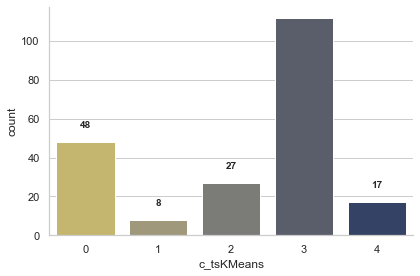

In [1009]:
sns.set(rc={'figure.figsize':(6,4)})
sns.set_style("whitegrid")
ax=sns.countplot(data=ds_map,x="c_tsKMeans",palette=cmap)
for p in ax.patches:
   ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()+7.5), ha='center', size=10, weight='bold')
plt.tight_layout()
sns.despine()
plt.show()

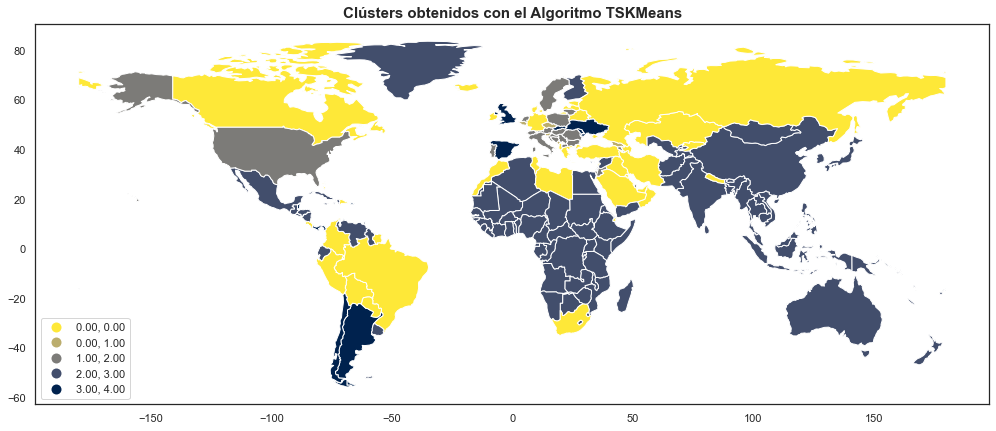

In [1010]:
map_plot(ds_map,"c_tsKMeans","natural_breaks","Clústers obtenidos con el Algoritmo TSKMeans")

## Clasificación
Para verificar los algoritmos de clustering se aplican técnicas de clasificación en miras a relaciona la exactitud obtenida en esta etapa con el correcto agrupamiento de los algoritmos

In [1166]:
#Función para retornar una columna como array
def return_column(matrix, col):
    return np.array([row[col] for row in matrix])

Se clasifica usando **LogisticRegression** y separando los datos en 80% (X_train, Y_train) de datos para entrenar y 20% para test (X_test, Y_test).

In [1192]:
class_model=LogisticRegression()

### Dataset con campos acumulados
Se verifica la exactitud para los cuatro modelos entrenados con este dataset. 

In [1370]:
ds_accum.head()

,countryterritoryCode,cases,deaths,popData2019,c_KPrototype,c_KMeans,c_wOneHot,c_GMixture
0,0,5,0,106310.0,0,0,2,0
1,0,5,0,106310.0,0,0,2,0
2,0,5,0,106310.0,0,0,2,0
3,0,5,0,106310.0,0,0,2,0
4,0,6,0,106310.0,0,0,2,0


Dividimos el dataset en un array de atributos (x) y un array de la clase de salida (y)

In [1372]:
ds_accum[code] = le.fit_transform(ds_accum[code])
array = ds_accum.values
x=array[:,1:4]
y=[]
# se crea un array y para cada algoritmo
for j in range(-4,0):
    y.append(return_column(array,j).reshape(-1,1))
ds_accum[code] = le.inverse_transform(ds_accum[code])

# Normalización de los atributos de entrada
norm_x = MinMaxScaler() # El rango por defecto de esta función es [0, 1]
x_fit = norm_x.fit(x)
x = x_fit.transform(x)

In [1373]:
clusters=ds_accum.columns[4:]

In [1375]:
results = []
names = []
Y_predict=[]
Y_test=[]
i=0
print("\033[1m{:<15} {:<15} {:<15}".format("Algoritmo","Train Acc","Test Acc\033[0m"))
for name in clusters:
    X_train, X_test, y_train,y_test=train_test_split(x, y[i], test_size=0.2, random_state=42, shuffle=True)
    Y_test.append(y_test.reshape(1,-1)[0])
    names.append(name)
    kfold = StratifiedKFold(n_splits=10,random_state=1,shuffle=True)
    # Validación cruzada k-fold
    cv_results = cross_val_score(class_model,X_train,y_train,cv=kfold,scoring="accuracy")
    results.append(cv_results)
    # Validación cruzada simple
    class_model.fit(X_train,y_train)
    Y_predict.append(class_model.predict(X_test))
    val_results = class_model.score(X_test,y_test) # exactitud de la predicción
    print ("{:<15} {:<15.5f} {:<15.5f}".format(name,cv_results.mean(),val_results))
    i+=1

Algoritmo       Train Acc       Test Acc   
c_KPrototype    0.83594         0.84356        
c_KMeans        0.83588         0.84356        
c_wOneHot       0.83590         0.84356        
c_GMixture      0.56541         0.56418        


Se realiza la comparación gráfica de los cuatro algoritmos.

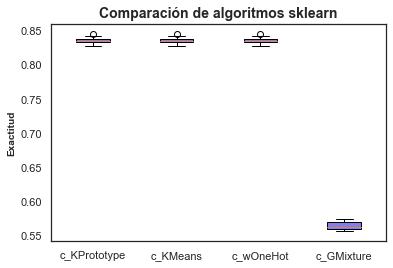

In [1376]:
# Configuración del área gráfica
fig, ax1 = plt.subplots(figsize=(6, 4))
sns.set_style("whitegrid")
sns.set_context("paper",font_scale=0.95,rc={"lines.linewidth": 1})
ax1.set_title("Comparación de algoritmos sklearn",fontweight ="bold", fontsize="14")
ax1.set_ylabel("Exactitud",fontweight ="bold", fontsize="10")
plt.boxplot(results, labels=names,patch_artist=True,
            boxprops=dict(facecolor=(0.0, 0.0, 0.9, 0.5)),
            whiskerprops=dict(ls="dashed"),widths=0.4)
plt.show()

Se evalúa la clasificación del array de test para los tres algoritmos. Para ello se usa la matriz de confusión y el reporte de clasificación que provee **Scikit Learn**.

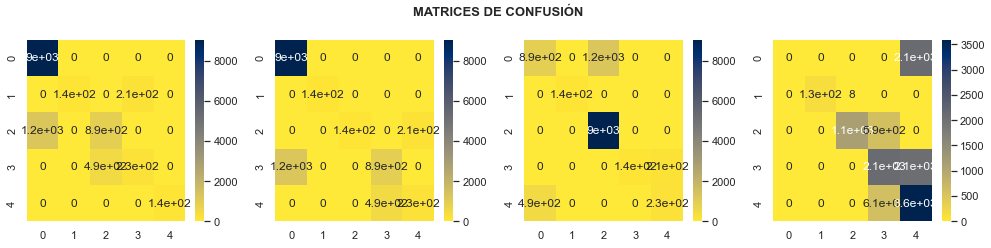

In [1379]:
sns.set(rc={'figure.figsize':(14,3.5)})
sns.set_style("white")
fig,axes = plt.subplots(1,4)
fig.suptitle('MATRICES DE CONFUSIÓN',fontweight ="bold", fontsize="13")

i=0
for name in clusters:
    cm = confusion_matrix(Y_test[i], Y_predict[i],labels=[0,1,2,3,4])
    sns.heatmap(cm, annot=True,ax=axes[i],cmap=cmap)
    i+=1
    
fig.tight_layout()
plt.show()

In [1380]:
print("\033[1mREPORTE DE CLASIFICACIÓN\033[0m")
i=0
for name in clusters:
    print("\033[4m"+ name + "\033[0m")
    print(classification_report(Y_test[i], Y_predict[i]))
    i+=1

REPORTE DE CLASIFICACIÓN
c_KPrototype
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94      9032
         1.0       1.00      0.40      0.57       344
         2.0       0.65      0.42      0.51      2124
         3.0       0.53      0.32      0.40       721
         4.0       1.00      1.00      1.00       135

    accuracy                           0.84     12356
   macro avg       0.81      0.63      0.68     12356
weighted avg       0.82      0.84      0.82     12356

c_KMeans
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94      9032
         1.0       1.00      1.00      1.00       135
         2.0       1.00      0.40      0.57       344
         3.0       0.65      0.42      0.51      2124
         4.0       0.53      0.32      0.40       721

    accuracy                           0.84     12356
   macro avg       0.81      0.63      0.68     12356
weighted avg       0.82      0

### Dataset agrupado
Se verifica la exactitud para los cuatro modelos entrenados con este dataset. 

In [1165]:
ds_group.head()

,cases,deaths,popData2019,c_KMeans,c_GMixture,c_FCM
countryterritoryCode,,,,,,
ABW,532171,5112,106310.0,0,0,4
AFG,7843873,288858,38041757.0,0,0,4
AGO,1482574,36783,31825299.0,0,0,4
AIA,1809,0,14872.0,0,0,4
ALB,4634190,108352,2862427.0,0,0,4


Dividimos el dataset en un array de atributos (x) y un array de la clase de salida (y)

In [1186]:
ds_group=ds_group.reset_index()
ds_group[code] = le.fit_transform(ds_group[code])
array = ds_group.values
x=array[:,1:4]
y=[]
# se crea un array y para cada algoritmo
for j in range(-3,0):
    y.append(return_column(array,j).reshape(-1,1))
ds_group[code] = le.inverse_transform(ds_group[code])

# Normalización de los atributos de entrada
norm_x = MinMaxScaler() # El rango por defecto de esta función es [0, 1]
x_fit = norm_x.fit(x)
x = x_fit.transform(x)

In [1189]:
clusters=ds_group.columns[5:]

Se clasifica usando **LogisticRegression** y separando los datos en 80% (X_train, Y_train) de datos para entrenar y 20% para test (X_test, Y_test).

In [1192]:
class_model=LogisticRegression()

In [1355]:
results = []
names = []
Y_predict=[]
Y_test=[]
i=0
print("\033[1m{:<15} {:<15} {:<15}".format("Algoritmo","Train Acc","Test Acc\033[0m"))
for name in clusters:
    X_train, X_test, y_train,y_test=train_test_split(x, y[i], test_size=0.2, random_state=42, shuffle=True)
    Y_test.append(y_test.reshape(1,-1)[0])
    names.append(name)
    kfold = StratifiedKFold(n_splits=10,random_state=1,shuffle=True)
    # Validación cruzada k-fold
    cv_results = cross_val_score(class_model,X_train,y_train,cv=kfold,scoring="accuracy")
    results.append(cv_results)
    # Validación cruzada simple
    class_model.fit(X_train,y_train)
    Y_predict.append(class_model.predict(X_test))
    val_results = class_model.score(X_test,y_test) # exactitud de la predicción
    print ("{:<15} {:<15.5f} {:<15.5f}".format(name,cv_results.mean(),val_results))
    i+=1

Algoritmo       Train Acc       Test Acc   
c_KMeans        0.97647         1.00000        
c_GMixture      0.97647         1.00000        
c_FCM           0.88787         0.86047        


Se realiza la comparación gráfica de los cuatro algoritmos.

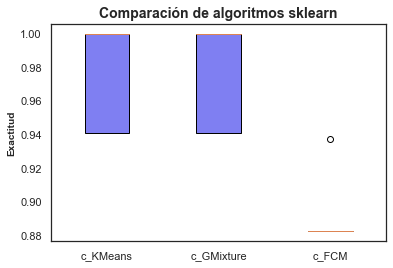

In [1356]:
# Configuración del área gráfica
fig, ax1 = plt.subplots(figsize=(6, 4))
sns.set_style("whitegrid")
sns.set_context("paper",font_scale=0.95,rc={"lines.linewidth": 1})
ax1.set_title("Comparación de algoritmos sklearn",fontweight ="bold", fontsize="14")
ax1.set_ylabel("Exactitud",fontweight ="bold", fontsize="10")
plt.boxplot(results, labels=names,patch_artist=True,
            boxprops=dict(facecolor=(0.0, 0.0, 0.9, 0.5)),
            whiskerprops=dict(ls="dashed"),widths=0.4)
plt.show()

Se evalúa la clasificación del array de test para los tres algoritmos. Para ello se usa la matriz de confusión y el reporte de clasificación que provee **Scikit Learn**.

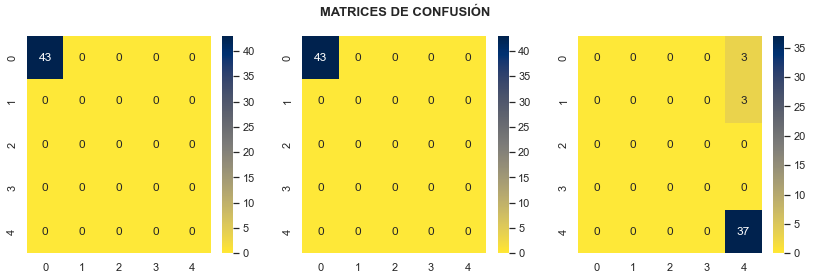

In [1367]:
sns.set(rc={'figure.figsize':(14,4)})
sns.set_style("white")
fig,axes = plt.subplots(1,3)
fig.suptitle('MATRICES DE CONFUSIÓN',fontweight ="bold", fontsize="13")

i=0
for name in clusters:
    cm = confusion_matrix(Y_test[i], Y_predict[i],labels=[0,1,2,3,4])
    sns.heatmap(cm, annot=True,ax=axes[i],cmap=cmap)
    i+=1

In [1369]:
print("\033[1mREPORTE DE CLASIFICACIÓN\033[0m")
i=0
for name in clusters:
    print("\033[4m"+ name + "\033[0m")
    print(classification_report(Y_test[i], Y_predict[i]))
    i+=1

REPORTE DE CLASIFICACIÓN
c_KMeans
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        43

    accuracy                           1.00        43
   macro avg       1.00      1.00      1.00        43
weighted avg       1.00      1.00      1.00        43

c_GMixture
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        43

    accuracy                           1.00        43
   macro avg       1.00      1.00      1.00        43
weighted avg       1.00      1.00      1.00        43

c_FCM
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.00      0.00      0.00         3
         4.0       0.86      1.00      0.92        37

    accuracy                           0.86        43
   macro avg       0.29      0.33      0.31        43
weighted avg       0.74      0.86      0.80        43



## Conclusiones
- Se realizaron varios análisis de clustering para determinar el impacto del COVID a nivel global. Los algoritmos con resultados más óptimos son aquellos basados en series temporales que permiten un mayor ajuste.
- Los mejores resultados se obtienen con el algoritmo basado en series temporales
- Al añadir parámetros que influyen también en la evolución de la enfermedad se determina que

<!--bibtex

@article{OWID-GH,
  author    = {OurWorldInData, },
  Title     = {covid-19-data},
  year      = {2022},
  url       = "https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-data.csv"
}

@article{CSSE-JHU,
  author    = {CSSE JHU, },
  Title     = {COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University},
  year      = {2022},
  url       = "https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports"
}

@article{pd-merge,
  author    = {Pandas, },
  Title     = {pandas.DataFrame.merge},
  year      = {2022},
  url       = "https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html"
}

@article{seaborn-plot:2021,
  author    = {Seaborn,},
  Title     = {Plotting with categorical data},
  year      = {2021},
  url       = "https://seaborn.pydata.org/tutorial/categorical.html"
}

@article{GPD:2022,
  author    = {Geopandas,},
  Title     = {Mapping and Plotting Tools},
  year      = {2022},
  url       = "https://geopandas.org/en/stable/docs/user_guide/mapping.html"
}

@article{MPL-CR,
  author    = {Matplotlib,},
  Title     = {Color Reference},
  year      = {2022},
  url       = "https://matplotlib.org/stable/tutorials/colors/colormaps.html"
}

@article{LOST,
  author    = {LOST,},
  Title     = {Line Graph with Labels at the Beginning or End of Lines},
  year      = {2022},
  url       = "https://lost-stats.github.io/Presentation/Figures/line_graph_with_labels_at_the_beginning_or_end.html"
}

@article{SKL-KM,
  author    = {Scikitlearn,},
  Title     = {sklearn.cluster.KMeans},
  year      = {2022},
  url       = "https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html"
}

@article{SKL-KM,
  author    = {Scikitlearn,},
  Title     = {sklearn.cluster.GaussianMixture},
  year      = {2022},
  url       = "https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html"
}

@article{CV19-IncidentRate,
  author    = {Sanitaria,},
  Title     = {¿Qué es la incidencia acumulada?},
  year      = {2022},
  url       = "https://www.redaccionmedica.com/recursos-salud/faqs-covid19/que-es-la-incidencia-acumulada-covid"
}

@article{CV19-FatalitytRate,
  author    = {OMS,},
  Title     = {Estimación de la mortalidad de la COVID-19},
  year      = {2020},
  url       = "https://www.redaccionmedica.com/recursos-salud/faqs-covid19/que-es-la-incidencia-acumulada-covid"
}

@book{TSL,
  author    = {tsLearn,},
  Title     = {tslearn’s documentation},
  year      = {2022},
  url       = "https://tslearn.readthedocs.io/en/stable/"
}
@book{KP,
  author    = {PyPi,},
  Title     = {kmodes},
  year      = {2022},
  url       = "https://pypi.org/project/kmodes/#huang97"
}

@article{KGL-TS,
  author    = {Kaggle,},
  Title     = {Introduction to Time Series Clustering},
  year      = {2021},
  url       = "https://www.kaggle.com/izzettunc/introduction-to-time-series-clustering"
}

@article{FCM,
  author    = {PyPI,},
  Title     = {fuzzy-c-means},
  year      = {2022},
  url       = "https://pypi.org/project/fuzzy-c-means/"
}

@article{TTSDUtil,
  author    = {tslearn,},
  Title     = {tslearn-utils-to-time-series-dataset},
  year      = {2022},
  url       = "https://tslearn.readthedocs.io/en/stable/gen_modules/utils/tslearn.utils.to_time_series_dataset.html#tslearn-utils-to-time-series-dataset"
}

@article{PH-FCM,
  author    = {SciKit-Fuzzy,},
  Title     = {Fuzzy c-means clustering},
  year      = {2022},
  url       = "https://pythonhosted.org/scikit-fuzzy/auto_examples/plot_cmeans.html"
}

-->

# References

<a name="cite-pd-merge"/><sup>[^](#ref-1) </sup>Pandas, . 2022. _pandas.DataFrame.merge_. [URL](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html)

<a name="cite-OWID-GH"/><sup>[^](#ref-2) </sup>OurWorldInData, . 2022. _covid-19-data_. [URL](https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-data.csv)

<a name="cite-CSSE-JHU"/><sup>[^](#ref-3) </sup>CSSE JHU, . 2022. _COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University_. [URL](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports)

<a name="cite-GPD:2022"/><sup>[^](#ref-4) </sup>Geopandas,. 2022. _Mapping and Plotting Tools_. [URL](https://geopandas.org/en/stable/docs/user_guide/mapping.html)

<a name="cite-LOST"/><sup>[^](#ref-5) </sup>LOST,. 2022. _Line Graph with Labels at the Beginning or End of Lines_. [URL](https://lost-stats.github.io/Presentation/Figures/line_graph_with_labels_at_the_beginning_or_end.html)

<a name="cite-seaborn-plot:2021"/><sup>[^](#ref-6) </sup>Seaborn,. 2021. _Plotting with categorical data_. [URL](https://seaborn.pydata.org/tutorial/categorical.html)

<a name="cite-MPL-CR"/><sup>[^](#ref-7) </sup>Matplotlib,. 2022. _Color Reference_. [URL](https://matplotlib.org/stable/tutorials/colors/colormaps.html)

<a name="cite-KP"/><sup>[^](#ref-8) </sup>PyPi,. 2022. _kmodes_. [URL](https://pypi.org/project/kmodes/#huang97)

<a name="cite-SKL-KM"/><sup>[^](#ref-9) </sup>Scikitlearn,. 2022. _sklearn.cluster.GaussianMixture_. [URL](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)

<a name="cite-CV19-IncidentRate"/><sup>[^](#ref-11) </sup>Sanitaria,. 2022. _¿Qué es la incidencia acumulada?_. [URL](https://www.redaccionmedica.com/recursos-salud/faqs-covid19/que-es-la-incidencia-acumulada-covid)

<a name="cite-CV19-FatalitytRate"/><sup>[^](#ref-12) </sup>OMS,. 2020. _Estimación de la mortalidad de la COVID-19_. [URL](https://www.redaccionmedica.com/recursos-salud/faqs-covid19/que-es-la-incidencia-acumulada-covid)

<a name="cite-PH-FCM"/><sup>[^](#ref-13) </sup>SciKit-Fuzzy,. 2022. _Fuzzy c-means clustering_. [URL](https://pythonhosted.org/scikit-fuzzy/auto_examples/plot_cmeans.html)

<a name="cite-TSL"/><sup>[^](#ref-14) </sup>tsLearn,. 2022. _tslearn’s documentation_. [URL](https://tslearn.readthedocs.io/en/stable/)

<a name="cite-KGL-TS"/><sup>[^](#ref-15) </sup>Kaggle,. 2021. _Introduction to Time Series Clustering_. [URL](https://www.kaggle.com/izzettunc/introduction-to-time-series-clustering)

<a name="cite-TTSDUtil"/><sup>[^](#ref-16) </sup>tslearn,. 2022. _tslearn-utils-to-time-series-dataset_. [URL](https://tslearn.readthedocs.io/en/stable/gen_modules/utils/tslearn.utils.to_time_series_dataset.html#tslearn-utils-to-time-series-dataset)

